# 1. Overview

This is a notebook for training models to submit predictions to the "Diabetes Prediction Challenge" Kaggle competition ([playground-series-s5e12](https://www.kaggle.com/competitions/playground-series-s5e12)).

Synthetic data is used for this playground competition, and the objective is to, for each patient in the test set, predict the probability that the patient will be diagnosed with diabetes.

# 2. Setup

## 2.1 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
import lightgbm as lgb
import optuna
import os
import hashlib as hl # for StackingEstimator
import inspect # for StackingEstimator
import random
import warnings
from catboost import CatBoostClassifier
from enum import Enum
from pathlib import Path # for StackingPredictionsRetriever
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression # for meta model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from types import FunctionType
from xgboost import XGBClassifier, XGBRFClassifier

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pd.set_option('display.max_colwidth', None) # Display full column content
pd.set_option('display.max_rows', None) # Display all rows
pd.set_option('display.width', 1000) # Set larger display width

## 2.2 Reproducibility

For reproducibility of results, an arbitrary number will be used for the random seed.

In [2]:
RANDOM_SEEDS = [11, 42]
random.seed(RANDOM_SEEDS[0])
np.random.seed(RANDOM_SEEDS[0])
torch.manual_seed(RANDOM_SEEDS[0])
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEEDS[0])
    torch.cuda.manual_seed_all(RANDOM_SEEDS[0])

## 2.3 Device

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.4 DataFrames

Read the data provided for the competition into dataframes.

In [4]:
INPUT_DIR = '/kaggle/input'
orig_train_data = pd.read_csv(os.path.join(INPUT_DIR, 'playground-series-s5e12/train.csv'))
orig_test_data = pd.read_csv(os.path.join(INPUT_DIR, 'playground-series-s5e12/test.csv'))

# set index
orig_train_data.set_index('id', inplace=True)
orig_test_data.set_index('id', inplace=True)

# target column
target_col = "diagnosed_diabetes"

# 3. Exploratory Data Analysis

In [5]:
# to skip the generation of plots (e.g. KDE) in this section that take time; set to False to generate the plots 
SKIP_PLOTS = True

In [6]:
orig_train_data.describe()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,50.359734,2.072411,80.230803,5.963695,7.002200,6.012733,25.874684,0.858766,116.294193,75.440924,70.167749,186.818801,53.823214,102.905854,123.081850,0.149401,0.181990,0.030324,0.623296
std,11.655520,1.048189,51.195071,1.463336,0.901907,2.022707,2.860705,0.037980,11.010390,6.825775,6.938722,16.730832,8.266545,19.022416,24.739397,0.356484,0.385837,0.171478,0.484560
min,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.680000,91.000000,51.000000,42.000000,117.000000,21.000000,51.000000,31.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,1.000000,49.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,175.000000,48.000000,89.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,2.000000,71.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000,1.000000
75%,58.000000,3.000000,96.000000,7.000000,7.600000,7.400000,27.800000,0.880000,124.000000,80.000000,75.000000,199.000000,59.000000,116.000000,139.000000,0.000000,0.000000,0.000000,1.000000
max,89.000000,9.000000,747.000000,9.900000,9.900000,16.500000,38.400000,1.050000,163.000000,104.000000,101.000000,289.000000,90.000000,205.000000,290.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
orig_test_data.describe()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,50.432397,2.089693,92.349087,5.945838,6.997795,6.011278,25.881906,0.859007,116.374117,75.396013,70.048350,187.308620,53.813557,103.416083,123.538480,0.152920,0.184410,0.033110
std,11.938741,1.066214,62.187399,1.481068,0.914693,2.060472,2.894289,0.038523,11.252146,6.950340,7.090543,18.413053,8.398126,20.571855,28.965441,0.359911,0.387819,0.178924
min,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.690000,91.000000,51.000000,42.000000,107.000000,22.000000,51.000000,31.000000,0.000000,0.000000,0.000000
25%,42.000000,1.000000,51.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,174.000000,48.000000,89.000000,104.000000,0.000000,0.000000,0.000000
50%,50.000000,2.000000,77.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000
75%,59.000000,3.000000,115.000000,7.000000,7.600000,7.400000,27.800000,0.890000,124.000000,80.000000,75.000000,200.000000,60.000000,117.000000,142.000000,0.000000,0.000000,0.000000
max,89.000000,9.000000,748.000000,9.900000,9.900000,15.900000,38.300000,1.050000,170.000000,104.000000,101.000000,285.000000,91.000000,226.000000,290.000000,1.000000,1.000000,1.000000


In [8]:
numeric_col_names = orig_train_data.select_dtypes(include='number').columns.to_series()
categorical_col_names = orig_train_data.select_dtypes(include='object').columns.to_series()
assert numeric_col_names.size + categorical_col_names.size == orig_train_data.shape[1]

# drop target column from numeric column names
numeric_col_names.drop(target_col, inplace=True)

In [9]:
for (dataset_name, dataset) in [('Train data', orig_train_data), ('Test data', orig_test_data)]:
    print(f"##### {dataset_name} missing values #####")
    print(dataset.isnull().sum())
    print()

##### Train data missing values #####
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
di

In [10]:
for (dataset_name, dataset) in [('Train data', orig_train_data), ('Test data', orig_test_data)]:
    print(f"##### {dataset_name} categorical cols unique values #####")
    for categorical_col_name in categorical_col_names:
        print(f"{categorical_col_name}:")
        print(dataset[categorical_col_name].unique())
    print()

##### Train data categorical cols unique values #####
gender:
['Female' 'Male' 'Other']
ethnicity:
['Hispanic' 'White' 'Asian' 'Black' 'Other']
education_level:
['Highschool' 'Graduate' 'Postgraduate' 'No formal']
income_level:
['Lower-Middle' 'Upper-Middle' 'Low' 'Middle' 'High']
smoking_status:
['Current' 'Never' 'Former']
employment_status:
['Employed' 'Retired' 'Student' 'Unemployed']

##### Test data categorical cols unique values #####
gender:
['Female' 'Male' 'Other']
ethnicity:
['White' 'Hispanic' 'Black' 'Asian' 'Other']
education_level:
['Highschool' 'Graduate' 'Postgraduate' 'No formal']
income_level:
['Middle' 'Low' 'Lower-Middle' 'Upper-Middle' 'High']
smoking_status:
['Former' 'Never' 'Current']
employment_status:
['Employed' 'Unemployed' 'Retired' 'Student']



In [11]:
# KDE plots of target variable and numerical features
if not SKIP_PLOTS:
    plt.figure(figsize=(12, 24))
    kdeplot_col_names = [target_col]
    kdeplot_col_names.extend(numeric_col_names)
    for i, col in enumerate(kdeplot_col_names, start=1):
        plt.subplot(10, 2, i)
        sns.kdeplot(data=orig_train_data, x=col, fill=True)
        plt.tight_layout()
        plt.title(f"KDE plot of {col}")

In [12]:
if not SKIP_PLOTS:
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        orig_train_data[numeric_col_names].corr(),
        cmap='Reds',
        annot=True,
        linewidths=2,
        fmt='.2f',
        vmin=-1,
        vmax=1
    )
    plt.title('Correlation Matrix of Numerical Features', fontsize=18, pad=20)
    plt.show()

# 4. Data Pre-Processing

In [13]:
train_data = orig_train_data.copy()
test_data = orig_test_data.copy()

## 4.1 Ordinal Encoding

In [14]:
# education level
education_level_encoder = OrdinalEncoder(categories=[['No formal', 'Highschool', 'Graduate', 'Postgraduate']])
train_data['education_level_encoded'] = education_level_encoder.fit_transform(train_data[['education_level']])
test_data['education_level_encoded'] = education_level_encoder.fit_transform(test_data[['education_level']])

# income level
income_level_encoder = OrdinalEncoder(categories=[['Low', 'Lower-Middle','Middle', 'Upper-Middle', 'High']])
train_data['income_level_encoded'] = income_level_encoder.fit_transform(train_data[['income_level']])
test_data['income_level_encoded'] = income_level_encoder.fit_transform(test_data[['income_level']])

# smoking status
smoking_status_encoder = OrdinalEncoder(categories=[['Never', 'Former', 'Current']])
train_data['smoking_status_encoded'] = smoking_status_encoder.fit_transform(train_data[['smoking_status']])
test_data['smoking_status_encoded'] = smoking_status_encoder.fit_transform(test_data[['smoking_status']])

# drop original cols
for col in ['income_level', 'education_level', 'smoking_status']:
    train_data.drop(col, axis=1, inplace=True)
    test_data.drop(col, axis=1, inplace=True)

# print out value maps to check assigned values are as expected
for (encoded_col_name, encoder) in [
    ('education_level_encoded', education_level_encoder),
    ('income_level_encoded', income_level_encoder),
    ('smoking_status_encoded', smoking_status_encoder),
]:
    categories = encoder.categories_[0]
    value_map = { category: i for i, category in enumerate(categories) }
    print(f"{encoded_col_name}:\n{value_map}")

education_level_encoded:
{'No formal': 0, 'Highschool': 1, 'Graduate': 2, 'Postgraduate': 3}
income_level_encoded:
{'Low': 0, 'Lower-Middle': 1, 'Middle': 2, 'Upper-Middle': 3, 'High': 4}
smoking_status_encoded:
{'Never': 0, 'Former': 1, 'Current': 2}


## 4.2 Data Cleaning

In [15]:
def fix_blood_pressure(df):
    mask = df['diastolic_bp'] > df['systolic_bp']
    df.loc[mask, ['systolic_bp', 'diastolic_bp']] = (
        df.loc[mask, ['diastolic_bp', 'systolic_bp']].values
    )
    return df

train_data = fix_blood_pressure(train_data)
test_data = fix_blood_pressure(test_data)

## 4.3 Feature Generation

In [16]:
def add_generated_features(df):
    # log transforms for skewed data
    for col in ['triglycerides', 'ldl_cholesterol', 'cholesterol_total']:
        df[f'log_{col}'] = np.log1p(df[col])

    # medical ratios & interactions
    df['cholesterol_ratio'] = df['cholesterol_total'] / (df['hdl_cholesterol'] + 1e-5)
    df['ldl_hdl_ratio'] = df['ldl_cholesterol'] / (df['hdl_cholesterol'] + 1e-5)
    df['pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']
    df['mean_arterial_pressure'] = (df['systolic_bp'] + 2 * df['diastolic_bp']) / 3
    df['age_x_bmi'] = df['age'] * df['bmi']
    df['waist_x_bmi'] = df['waist_to_hip_ratio'] * df['bmi']
    df['family_history_diabetes_x_log_triglycerides'] = df['family_history_diabetes'] * df['log_triglycerides']
    df['hypertension_history_x_systolic_bp'] = df['hypertension_history'] * df['systolic_bp']
    df['activity_x_diet'] = df['physical_activity_minutes_per_week'] * df['diet_score']
    df['atherogenic_index'] = np.log((df['triglycerides'] / (df['hdl_cholesterol'] + 1e-5)) + 1e-5)
    df['non_hdl_cholesterol'] = df['cholesterol_total'] - df['hdl_cholesterol']
    df['map_x_bmi'] = df['mean_arterial_pressure'] * df['bmi']
    df['lipid_accumulation_proxy'] = df['waist_to_hip_ratio'] * df['log_triglycerides']
    df['visceral_adiposity_proxy'] = (df['bmi'] * df['triglycerides']) / (df['hdl_cholesterol'] + 1e-5)

    # squared
    df['age_sq'] = df['age'] ** 2
    df['bmi_sq'] = df['bmi'] ** 2
    df['waist_to_hip_ratio_sq'] = df['waist_to_hip_ratio'] ** 2
    df['systolic_bp_sq'] = df['systolic_bp'] ** 2

    # risk grouping
    df['comorbidity_count'] = (
        df['hypertension_history'] + df['cardiovascular_history'] + df['family_history_diabetes']
    )

    # binning
    df['bmi_cat'] = pd.cut(df['bmi'], bins=[-1, 25, 30, 100], labels=[0, 1, 2]).astype(int)
    df['bp_cat'] = pd.cut(
        df['systolic_bp'], 
        bins=[-1, 120, 130, 140, 300], # AHA Guidelines: Normal < 120, Elevated 120-129, Stage 1 130-139, Stage 2 >= 140
        labels=[0, 1, 2, 3] # Normal, Elevated, Stage 1, Stage 2
    ).astype(int)
    df['cholesterol_cat'] = pd.cut(
        df['cholesterol_total'], 
        bins=[-1, 200, 240, 1000], # ATP III Guidelines: Optimal < 200, Borderline 200-239, High >= 240
        labels=[0, 1, 2]
    ).astype(int)
    df['hdl_cat'] = pd.cut(
        df['hdl_cholesterol'], 
        bins=[-1, 40, 60, 200], # Inverted Risk: Risk < 40, Normal 40-60, Protective > 60
        labels=[2, 1, 0] # 2 is worst (Low HDL)
    ).astype(int)
    df['ldl_cat'] = pd.cut(
        df['ldl_cholesterol'], 
        bins=[-1, 100, 130, 160, 190, 1000], # ATP III Guidelines: Optimal < 100, Near Optimal 100-129, Borderline High 130-159, High 160-189, Very High >= 190
        labels=[0, 1, 2, 3, 4] # 0 is best (Optimal), 4 is worst (Very High)
    ).astype(int)

    # quantile binning
    quantile_cols = [
        'triglycerides', 'waist_to_hip_ratio', 'bmi', 'mean_arterial_pressure'
    ]
    for col in quantile_cols:
        df[f'{col}_decile'] = pd.qcut(df[col], q=10, labels=False, duplicates='drop').astype(int)

    # relative BMI, BP and cholesterol
    df['age_decade'] = (df['age'] // 10).astype(int)
    for group_col in ['age_decade', 'hypertension_history']:
        for num_col in ['bmi', 'systolic_bp', 'cholesterol_total']:
            group_means = df.groupby(group_col)[num_col].transform('mean')
            df[f'{num_col}_relative_to_{group_col}'] = df[num_col] - group_means

    # bin interactions
    df['age_bp_interaction'] = df['age_decade'].astype(str) + '_' + df['bp_cat'].astype(str)
    df['age_bp_interaction'] = df['age_bp_interaction'].astype('category').cat.codes

In [17]:
def add_kmeans_features(train_df, test_df, n_clusters):
    features_to_cluster = [
        'age', 'bmi', 'mean_arterial_pressure', 'cholesterol_ratio', 'log_triglycerides'
    ]
    
    combined = pd.concat([train_df[features_to_cluster], test_df[features_to_cluster]], axis=0)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEEDS[0], n_init=10)
    clusters = kmeans.fit_predict(scaled_data)

    train_dists = kmeans.transform(scaled_data[:len(train_df)])
    test_dists = kmeans.transform(scaled_data[len(train_df):])

    train_df['cluster_label'] = clusters[:len(train_df)].astype(object)
    test_df['cluster_label'] = clusters[len(train_df):].astype(object)

    for i in range(n_clusters):
        train_df[f'dist_to_cluster_{i}'] = train_dists[:, i]
        test_df[f'dist_to_cluster_{i}'] = test_dists[:, i]

    return train_df, test_df

In [18]:
# add generated features
add_generated_features(train_data)
add_generated_features(test_data)

# apply clustering
train_data, test_data = add_kmeans_features(train_data, test_data, n_clusters=7)

In [19]:
train_data.columns

Index(['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes', 'education_level_encoded', 'income_level_encoded', 'smoking_status_encoded', 'log_triglycerides', 'log_ldl_cholesterol', 'log_cholesterol_total', 'cholesterol_ratio', 'ldl_hdl_ratio', 'pulse_pressure', 'mean_arterial_pressure', 'age_x_bmi', 'waist_x_bmi', 'family_history_diabetes_x_log_triglycerides', 'hypertension_history_x_systolic_bp', 'activity_x_diet', 'atherogenic_index', 'non_hdl_cholesterol', 'map_x_bmi', 'lipid_accumulation_proxy', 'visceral_adiposity_proxy', 'age_sq', 'bmi_sq', 'waist_to_hip_ratio_sq', 'systolic_bp_sq', 'comorbidity_count',


## 4.4 Remaining Categorical Features

In [20]:
cat_features = train_data.drop(target_col, axis=1).select_dtypes(include='object').columns.to_list()
if len(cat_features) > 0:
    for col in cat_features:
        train_data[col] = train_data[col].astype('category')
        test_data[col] = test_data[col].astype('category')

# 5. Stacking Initial Setup

We'll use stacking, an [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) strategy, to generate the predictions. As we'll need to gather predictions from various base models (a.k.a. level-0 models) to feed as input features to a meta model (a.k.a. level-1 model), in order to streamline the process of experimenting with different combinations of base models, some helper classes will be defined in this section. These classes can also be found [here](https://github.com/chuo-v/machine-learning-utils/blob/master/ensemble-learning/stacking/stacking_predictions_retriever.py) at one of my GitHub repositories used to organize some utilities I implemented for machine learning.

In [21]:
class StackingEstimator:
    """
    A class representing an estimator that will be used for stacking, an ensemble learning strategy.

    Intended to be used in conjunction with the `StackingPredictionsRetriever` class, which helps
    retrieve predictions for multiple instances of `StackingEstimator`; as the predictions are saved
    in files, on subsequent requests to retrieve predictions, even as the set of estimators has been
    modified, the `StackingPredictionsRetriever` class can determine the predictions of estimators
    that are non-stale and available (if any) by using the `get_hash` method of the `StackingEstimator`
    class to determine the relevance and staleness of any saved predictions.

    Proper usage of this class requires one important condition to be satisfied: the predictions made
    using the estimator are determinstic, i.e. they are exactly the same everytime the estimator is
    run with the same inputs (`name`, `params_dict`, `feature_names`, `get_predictions`).
    """
    name = ""
    params_dict = {}
    feature_names = []
    get_predictions = lambda: None

    def __init__(
        self,
        name: str,
        feature_names: [str],
        params_dict: {},
        get_preds: FunctionType
    ):
        """
        Initializes a new instance of `StackingEstimator`.

        :param name:
            A string representing a name for the estimator. It is used for the column names of
            the training and test predictions for each estimator, and is also used as an input
            to calculate a hash value for the estimator. It is recommended to use a different
            name from the names used for other estimators passed to `StackingPredictionsRetriever`.
        :param feature_names:
            A list of strings representing the names of the features that will be used for the
            estimator. It will be passed as an argument to `get_preds`. Internally, it is only
            used as an input to calculate a hash value for the estimator.
        :param params_dict:
            A dictionary of parameters that will be specified for the estimator. It will be
            passed as an argument to `get_preds`. Internally, it is only used as an input
            to calculate a hash value for the estimator.
        :param get_preds:
            A function for getting the predictions for the estimator. It should only take two
            arguments: 'params_dict' and 'feature_names', and should return predictions for
            the training and test data (in that order) as a tuple of two `pandas.Series`.
        """
        # parameter check
        if not isinstance(name, str):
            raise ValueError("`name` argument should be of type `str`")
        if not isinstance(feature_names, list):
            raise ValueError(f"`feature_names` argument for estimator \"{name}\" should be of type `list`")
        elif not all(isinstance(feature_name, str) for feature_name in feature_names):
            raise ValueError(f"`feature_names` argument for estimator \"{name}\" should only contain instances of `str`")
        if not isinstance(params_dict, dict):
            raise ValueError(f"`params_dict` argument for estimator \"{name}\" should be of type `dict`")
        get_preds_params = inspect.signature(get_preds).parameters.values()
        get_preds_param_names = [param.name for param in get_preds_params]
        if len(get_preds_param_names) != 2:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take two arguments")
        elif "params_dict" not in get_preds_param_names:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take a \"params_dict\" argument")
        elif "feature_names" not in get_preds_param_names:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take a \"feature_names\" argument")

        self.name = name
        self.feature_names = feature_names
        self.params_dict = params_dict
        self.get_preds = get_preds

    def get_hash_value(self):
        """
        Calculates and returns a hash value for the estimator using
        `name`, `feature_names` and `params_dict` as inputs.
        """
        feature_names_str = "_".join(sorted(self.feature_names))
        params_dict_str = "_".join(f"{key}-{value}" for (key, value) in sorted(self.params_dict.items()))
        hash_input_str = "_".join([self.name, feature_names_str, params_dict_str])
        md5_hash = hl.md5(hash_input_str.encode('utf-8')).hexdigest()
        return md5_hash

class StackingPredictionsRetriever:
    """
    A class for streamlining stacking (an ensemble learning strategy) that saves predictions
    from estimators to file so that when trying out different combinations of (base) estimators,
    the predictions that are not stale can be reused, saving the time of having the estimators
    make predictions again.

    Intended to be used in conjunction with the `StackingEstimator` class. The `hash_value` of
    `StackingEstimator` is used to determine the staleness and relevance of the predictions for
    an estimator. The implementation for making predictions using an estimator needs to be
    provided as a function to `get_preds` for `StackingEstimator`; when predictions need to be
    made using an estimator, this class will call `get_preds` for the `StackingEstimator` instance.

    Proper usage of this class requires one important condition to be satisfied: the predictions made
    using the estimators are determinstic, i.e. they are exactly the same everytime a
    `StackingEstimator` instance is run with the same inputs.
    """
    estimators = []
    working_dir_path = ""
    train_preds_filename = ""
    test_preds_filename = ""
    preds_save_interval = 0

    def __init__(
        self,
        estimators: [StackingEstimator],
        working_dir_path: str,
        train_preds_filename: str = "train_preds",
        test_preds_filename: str = "test_preds",
        preds_save_interval: int = 5,
    ):
        """
        Initializes a new instance of `StackingPredictionsRetriever`.

        :param estimators:
            A list of `StackingEstimator` instances for which the class will retrieve predictions.
        :param working_dir_path:
            The path for the working directory where the files with predictions will be saved.
        :param train_preds_filename:
            The name of the file in which predictions for the training set will be stored.
        :param test_preds_filename:
            The name of the file in which predictions for the test set will be stored.
        :param preds_save_interval:
            An integer which specifies the interval at which predictions will be saved when
            `get_preds` is called, corresponding to the number of estimators whose predictions
            have been retrieved since the predictions were previously saved. Any estimators
            whose predictions are not stale and therefore were not required to make predictions
            again are not included in this number.
        """
        # parameter check
        if not isinstance(estimators, list):
            raise ValueError("`estimators` must be passed as a list")
        if not all(isinstance(e, StackingEstimator) for e in estimators):
            raise ValueError("`estimators` should only contain instances of `StackingEstimator`")
        if not isinstance(working_dir_path, str):
            raise ValueError("`working_dir_path` argument should be of type `str`")
        if not isinstance(preds_save_interval, int):
            raise ValueError("`preds_save_interval` argument should be of type `int`")

        self.estimators = estimators
        self.working_dir_path = working_dir_path
        self.train_preds_filename = train_preds_filename
        self.test_preds_filename = test_preds_filename
        self.preds_save_interval = preds_save_interval

    def get_train_preds_file_path(self):
        """
        Returns the file path for storing predictions for training data.
        """
        return Path(f"{self.working_dir_path}/{self.train_preds_filename}.csv")

    def get_test_preds_file_path(self):
        """
        Returns the file path for storing predictions for test data.
        """
        return Path(f"{self.working_dir_path}/{self.test_preds_filename}.csv")

    def get_current_train_and_test_preds(self):
        """
        Returns the current predictions for training and test data (in that order)
        as a tuple of two `pandas.DataFrame`.

        The predictions are attempted to be retrieved from the file paths returned
        by `get_train_preds_file_path` and `get_test_preds_file_path`; if there are
        any issues with doing so (e.g. file does not exist, dataframe is empty),
        empty dataframes will be returned instead.
        In the case an `pandas.errors.EmptyDataError` exception is raised when
        reading from a file, the corresponding file will be removed.
        """
        curr_train_preds = pd.DataFrame()
        curr_test_preds = pd.DataFrame()
        train_preds_file_path = self.get_train_preds_file_path()
        test_preds_file_path = self.get_test_preds_file_path()

        if train_preds_file_path.is_file():
            try:
                curr_train_preds = pd.read_csv(train_preds_file_path)
            except pd.errors.EmptyDataError:
                train_preds_file_path.unlink()
        if test_preds_file_path.is_file():
            try:
                curr_test_preds = pd.read_csv(test_preds_file_path)
            except pd.errors.EmptyDataError:
                test_preds_file_path.unlink()

        return curr_train_preds, curr_test_preds

    def get_preds(self):
        """
        Retrieves predictions from all estimators in `estimators`, storing them in
        two files at the file paths specified by `working_dir_path`,
        `train_preds_filename` and `test_preds_filename`.

        If non-stale (relevant) predictions are found for an estimator, retrieval
        of predictions by calling `get_preds` on the estimator will be skipped,
        and the existing predictions for the estimator will be kept.
        """
        print("[INFO] Getting predictions..")
        curr_train_preds, curr_test_preds = self.get_current_train_and_test_preds()

        preds_retrieved_count = 0
        num_preds_retrieved_but_not_yet_saved = 0
        estimators_skipped = []

        for estimator in self.estimators:
            estimator_hash_value = estimator.get_hash_value()
            estimator_name = f"{estimator.name} ({estimator_hash_value})"

            # skip retrieving predictions for estimator if non-stale predictions are already available
            train_preds_available = any(estimator_hash_value in col_name for col_name in curr_train_preds.columns)
            test_preds_available = any(estimator_hash_value in col_name for col_name in curr_test_preds.columns)
            if train_preds_available and test_preds_available:
                estimators_skipped += [estimator_name]
                continue

            print(f"[INFO] Getting predictions for estimator {estimator_name}")
            train_preds, test_preds = estimator.get_preds(estimator.params_dict, estimator.feature_names)
            if not isinstance(train_preds, pd.core.series.Series):
                raise ValueError("`train_preds` should be of type `pandas.Series`")
            if not isinstance(test_preds, pd.core.series.Series):
                raise ValueError("`test_preds` should be of type `pandas.Series`")
            curr_train_preds[estimator_name] = train_preds
            curr_test_preds[estimator_name] = test_preds
            preds_retrieved_count += 1

            # save predictions at an interval of `preds_save_interval`
            if preds_retrieved_count % self.preds_save_interval == 0:
                curr_train_preds.sort_index(axis=1).to_csv(self.get_train_preds_file_path(), index=False)
                curr_test_preds.sort_index(axis=1).to_csv(self.get_test_preds_file_path(), index=False)
                num_preds_retrieved_but_not_yet_saved = 0
                print("[INFO] Saved predictions")
            else:
                num_preds_retrieved_but_not_yet_saved += 1

        if estimators_skipped:
            estimators_skipped.sort()
            formatted_estimators = ", ".join(estimators_skipped)
            print(f"[INFO] Skipped retrieving predictions for following estimators as their current ones are not stale:\n{formatted_estimators}")

        if num_preds_retrieved_but_not_yet_saved != 0:
            curr_train_preds.sort_index(axis=1).to_csv(self.get_train_preds_file_path(), index=False)
            curr_test_preds.sort_index(axis=1).to_csv(self.get_test_preds_file_path(), index=False)
            print("[INFO] Saved predictions")

        print("[INFO] Finished getting all predictions")

    def sync_preds(self):
        """
        Syncs the predictions stored at the two file paths specified by
        `working_dir_path`, `train_preds_filename` and `test_preds_filename` by
        removing predictions for any estimator that is not currently in `estimators`.

        Note that new predictions for estimators that do not currently have predictions
        in the files will not be added; `get_preds` should be used for this purpose
        instead.
        """
        print("[INFO] Syncing predictions..")
        estimator_hash_values = [estimator.get_hash_value() for estimator in self.estimators]
        should_remove_col = lambda col_name: not any(hash_value in col_name for hash_value in estimator_hash_values)

        curr_train_preds, curr_test_preds = self.get_current_train_and_test_preds()

        if not curr_train_preds.empty:
            col_names_to_remove = [col_name for col_name in curr_train_preds.columns if should_remove_col(col_name)]
            if col_names_to_remove:
                print(f"[INFO] Dropping columns for following estimators from training predictions:\n{col_names_to_remove}")
                curr_train_preds.drop(columns=col_names_to_remove, inplace=True)
                curr_train_preds.to_csv(self.get_train_preds_file_path(), index=False)
            else:
                print(f"[INFO] No columns for training predictions were dropped")
        if not curr_test_preds.empty:
            col_names_to_remove = [col_name for col_name in curr_test_preds.columns if should_remove_col(col_name)]
            if col_names_to_remove:
                print(f"[INFO] Dropping columns for following estimators from test predictions:\n{col_names_to_remove}")
                curr_test_preds.drop(columns=col_names_to_remove, inplace=True)
                curr_test_preds.to_csv(self.get_test_preds_file_path(), index=False)
            else:
                print(f"[INFO] No columns for test predictions were dropped")

        print("[INFO] Finished syncing predictions")

    def import_preds(self, input_dir_path):
        """
        Imports predictions stored at the two file paths at `input_dir_path` with
        `train_preds_filename` and `test_preds_filename` as their filenames. If no
        such files are found, no predictions will be imported.

        Only predictions for estimators specified in `estimators` will be imported.
        Any predictions for estimators that were already available will be overwritten
        with predictions for the same estimators found in the files at `input_dir_path`.

        :param input_dir_path:
            The path to the directory for the training and test predictions files.
            The file names are expected to be the same as `train_preds_filename`
            and `test_preds_filename`
        """
        print("[INFO] Importing predictions..")
        curr_train_preds, curr_test_preds = self.get_current_train_and_test_preds()
        input_train_preds = pd.DataFrame()
        input_test_preds = pd.DataFrame()

        input_train_preds_path = Path(f"{input_dir_path}/{self.train_preds_filename}.csv")
        input_test_preds_path = Path(f"{input_dir_path}/{self.test_preds_filename}.csv")
        if input_train_preds_path.is_file():
            try:
                input_train_preds = pd.read_csv(input_train_preds_path)
            except: pass
        if input_test_preds_path.is_file():
            try:
                input_test_preds = pd.read_csv(input_test_preds_path)
            except: pass

        estimators_with_imported_train_preds = []
        estimators_with_imported_test_preds = []
        for estimator in self.estimators:
            estimator_hash_value = estimator.get_hash_value()
            estimator_name = f"{estimator.name} ({estimator_hash_value})"
            train_preds_available = any(estimator_hash_value in col_name for col_name in input_train_preds.columns)
            test_preds_available = any(estimator_hash_value in col_name for col_name in input_test_preds.columns)

            if train_preds_available:
                curr_train_preds[estimator_name] = input_train_preds[estimator_name]
                estimators_with_imported_train_preds += [estimator_name]
            if test_preds_available:
                curr_test_preds[estimator_name] = input_test_preds[estimator_name]
                estimators_with_imported_test_preds += [estimator_name]

        if not estimators_with_imported_train_preds:
            print("[INFO] No train predictions were imported")
        else:
            curr_train_preds.sort_index(axis=1).to_csv(self.get_train_preds_file_path(), index=False)
            formatted_estimators = ", ".join(estimators_with_imported_train_preds)
            print(f"[INFO] {len(estimators_with_imported_train_preds)} train predictions were imported:\n{formatted_estimators}")
        if not estimators_with_imported_test_preds:
            print("[INFO] No test predictions were imported")
        else:
            curr_test_preds.sort_index(axis=1).to_csv(self.get_test_preds_file_path(), index=False)
            formatted_estimators = ", ".join(estimators_with_imported_test_preds)
            print(f"[INFO] {len(estimators_with_imported_test_preds)} test predictions were imported:\n{formatted_estimators}")
        
        print("[INFO] Finished importing predictions")

    def clear_preds(self):
        """
        Removes all stored predictions by deleting the two files at filepaths specified
        by `working_dir_path`, `train_preds_filename` and `test_preds_filename`.
        """
        train_preds_file_path = self.get_train_preds_file_path()
        test_preds_file_path = self.get_test_preds_file_path()

        if train_preds_file_path.is_file():
            train_preds_file_path.unlink()
        if test_preds_file_path.is_file():
            test_preds_file_path.unlink()

        print("[INFO] Finished clearing predictions")

Next, we'll simply create a variable for storing the estimators (`StackingEstimator` instances) that we'll pass to the `StackingPredictionsRetriever` class for getting all the predictions from our base models.

In [22]:
estimators = []

# 6. Feature Sets

In [23]:
# base feature set
FEATURE_SET_1 = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day',
    'bmi', 'waist_to_hip_ratio', 'systolic_bp',
    'diastolic_bp', 'heart_rate', 'cholesterol_total',
    'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
    'gender', 'ethnicity', 'employment_status',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history',
    'education_level_encoded', 'income_level_encoded', 'smoking_status_encoded',
    'log_triglycerides', 'log_ldl_cholesterol', 'log_cholesterol_total',
    'cholesterol_ratio', 'ldl_hdl_ratio', 'pulse_pressure',
    'mean_arterial_pressure', 'age_x_bmi', 'waist_x_bmi',
    'family_history_diabetes_x_log_triglycerides', 'hypertension_history_x_systolic_bp', 'activity_x_diet',
    'age_sq', 'bmi_sq', 'waist_to_hip_ratio_sq',
    'systolic_bp_sq', 'comorbidity_count', 'bmi_cat',
    'cluster_label',
]

# FEATURE_SET_2 = FEATURE_SET_1 + proxies + binned/relative features + clusters
FEATURE_SET_2 = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day',
    'bmi', 'waist_to_hip_ratio', 'systolic_bp',
    'diastolic_bp', 'heart_rate', 'cholesterol_total',
    'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
    'gender', 'ethnicity', 'employment_status',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history',
    'education_level_encoded', 'income_level_encoded', 'smoking_status_encoded',
    'log_triglycerides', 'log_ldl_cholesterol', 'log_cholesterol_total',
    'cholesterol_ratio', 'ldl_hdl_ratio', 'pulse_pressure',
    'mean_arterial_pressure', 'age_x_bmi', 'waist_x_bmi',
    'family_history_diabetes_x_log_triglycerides', 'hypertension_history_x_systolic_bp', 'activity_x_diet',
    'atherogenic_index', 'non_hdl_cholesterol', 'map_x_bmi',
    'lipid_accumulation_proxy', 'visceral_adiposity_proxy', 'age_sq',
    'bmi_sq', 'waist_to_hip_ratio_sq', 'systolic_bp_sq',
    'comorbidity_count', 'bmi_cat', 'bmi_relative_to_age_decade',
    'systolic_bp_relative_to_age_decade', 'cholesterol_total_relative_to_age_decade', 'bmi_relative_to_hypertension_history',
    'systolic_bp_relative_to_hypertension_history', 'cholesterol_total_relative_to_hypertension_history', 'cluster_label',
    'dist_to_cluster_0', 'dist_to_cluster_1', 'dist_to_cluster_2',
    'dist_to_cluster_3', 'dist_to_cluster_4', 'dist_to_cluster_5',
    'dist_to_cluster_6',
]

# FEATURE_SET_3 = FEATURE_SET_2 + additional binned features
FEATURE_SET_3 = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day',
    'bmi', 'waist_to_hip_ratio', 'systolic_bp',
    'diastolic_bp', 'heart_rate', 'cholesterol_total',
    'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
    'gender', 'ethnicity', 'employment_status',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history',
    'education_level_encoded', 'income_level_encoded', 'smoking_status_encoded',
    'log_triglycerides', 'log_ldl_cholesterol', 'log_cholesterol_total',
    'cholesterol_ratio', 'ldl_hdl_ratio', 'pulse_pressure',
    'mean_arterial_pressure', 'age_x_bmi', 'waist_x_bmi',
    'family_history_diabetes_x_log_triglycerides', 'hypertension_history_x_systolic_bp', 'activity_x_diet',
    'atherogenic_index', 'non_hdl_cholesterol', 'map_x_bmi',
    'lipid_accumulation_proxy', 'visceral_adiposity_proxy', 'age_sq',
    'bmi_sq', 'waist_to_hip_ratio_sq', 'systolic_bp_sq',
    'comorbidity_count', 'bmi_cat', 'bp_cat',
    'cholesterol_cat', 'hdl_cat', 'ldl_cat',
    'triglycerides_decile', 'waist_to_hip_ratio_decile', 'bmi_decile',
    'mean_arterial_pressure_decile', 'age_decade', 'bmi_relative_to_age_decade',
    'systolic_bp_relative_to_age_decade', 'cholesterol_total_relative_to_age_decade', 'bmi_relative_to_hypertension_history',
    'systolic_bp_relative_to_hypertension_history', 'cholesterol_total_relative_to_hypertension_history', 'age_bp_interaction',
    'cluster_label', 'dist_to_cluster_0', 'dist_to_cluster_1',
    'dist_to_cluster_2', 'dist_to_cluster_3', 'dist_to_cluster_4',
    'dist_to_cluster_5', 'dist_to_cluster_6',
]

# 7. Base Model Hyperparameter Tuning

In [24]:
# to skip hyperparameter tuning when it's not needed; set to `False` to do the tuning
SKIP_BASE_MODEL_HYPERPARAMETER_TUNING = True

# value set for early stopping for base models that support it; this value will be used for actual model training as well
BASE_MODEL_EARLY_STOPPING_ROUNDS = 100

In [25]:
class BaseModelOptunaStudyEstimator(Enum):
    CATBOOSTCLASSIFIER = "CatBoostClassifier"
    LGBMCLASSIFIER = "LGBMClassifier"
    XGBCLASSIFIER = "XGBClassifier"
    XGBCLASSIFIER_DART = "XGBClassifier_DART"

Manually configure the values for the following variables for different studies.

In [26]:
# estimator to use for Optuna study
BASE_MODEL_OPTUNA_STUDY_ESTIMATOR = BaseModelOptunaStudyEstimator.CATBOOSTCLASSIFIER

# feature set to use for Optuna study
BASE_MODEL_OPTUNA_STUDY_FEATURE_SET = FEATURE_SET_3

# maximum number of trials Optuna will conduct for the optimization
BASE_MODEL_OPTUNA_STUDY_NUM_TRIALS = 100

# number of splits to use for Stratified K-Fold Cross-Validation for Optuna study
BASE_MODEL_OPTUNA_STUDY_KFOLD_NUM_SPLITS = 3

In [27]:
def get_base_model_optuna_params(trial, study_estimator):
    if study_estimator == BaseModelOptunaStudyEstimator.CATBOOSTCLASSIFIER:
        if BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_1:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.04),
                'depth': trial.suggest_int('depth', 5, 7),
                'border_count': trial.suggest_int('border_count', 200, 254),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 50.0, log=True),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 0.5),
                'random_strength': trial.suggest_float('random_strength', 5.0, 20.0),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 100),
            }
        elif BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_2:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.10),
                'depth': trial.suggest_int('depth', 5, 8),
                'border_count': trial.suggest_int('border_count', 128, 254),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 10.0, 100.0, log=True),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_strength': trial.suggest_float('random_strength', 1.0, 10.0, log=True),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
            }
        elif BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_3:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.20),
                'depth': trial.suggest_int('depth', 3, 16),
                'border_count': trial.suggest_int('border_count', 32, 254),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 150.0, log=True),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_strength': trial.suggest_float('random_strength', 1.0, 10.0, log=True),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
            }
        else:
            raise ValueError(f"Search space for feature set for Optuna study not yet specified for CatBoostClassifier.")
    elif study_estimator == BaseModelOptunaStudyEstimator.LGBMCLASSIFIER:
        if BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_1:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.03),
                'num_leaves': trial.suggest_int('num_leaves', 20, 35),
                'min_child_samples': trial.suggest_int('min_child_samples', 350, 550),
                'min_split_gain': trial.suggest_float('min_split_gain', 0.001, 0.1, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 0.9),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.45),
                'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0, log=True),
            }
        elif BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_2:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.045),
                'num_leaves': trial.suggest_int('num_leaves', 30, 45),
                'min_child_samples': trial.suggest_int('min_child_samples', 300, 500),
                'min_split_gain': trial.suggest_float('min_split_gain', 1e-4, 0.2, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 0.9),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.35, 0.55),
                'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 20.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 20.0, 100.0, log=True),
            }
        elif BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_3:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.04),
                'num_leaves': trial.suggest_int('num_leaves', 15, 30),
                'min_child_samples': trial.suggest_int('min_child_samples', 100, 300),
                'min_split_gain': trial.suggest_float('min_split_gain', 1e-4, 0.1, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 0.95),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.40, 0.65),
                'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0, log=True),
            }
        else:
            raise ValueError(f"Search space for feature set for Optuna study not yet specified for LGBMClassifier.")
    elif study_estimator == BaseModelOptunaStudyEstimator.XGBCLASSIFIER:
        if BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_1:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.05),
                'max_depth': trial.suggest_int('max_depth', 2, 5),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
                'alpha': trial.suggest_float('alpha', 0.1, 10.0, log=True),
                'gamma': trial.suggest_float('gamma', 1.0, 3.0),
                'lambda': trial.suggest_float('lambda', 0.1, 10.0, log=True),
                'min_child_weight': trial.suggest_int('min_child_weight', 50, 200),
            }
        elif BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_2:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.008),
                'max_depth': trial.suggest_int('max_depth', 8, 11),
                'subsample': trial.suggest_float('subsample', 0.6, 0.9),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.25),
                'alpha': trial.suggest_float('alpha', 0.1, 10.0, log=True),
                'gamma': trial.suggest_float('gamma', 1.0, 5.0),
                'lambda': trial.suggest_float('lambda', 1.0, 10.0, log=True),
                'min_child_weight': trial.suggest_int('min_child_weight', 40, 100),
            }
        elif BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_3:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.08),
                'max_depth': trial.suggest_int('max_depth', 3, 5),
                'subsample': trial.suggest_float('subsample', 0.75, 0.95),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.10, 0.25),
                'alpha': trial.suggest_float('alpha', 0.1, 5.0, log=True),
                'gamma': trial.suggest_float('gamma', 0.1, 1.0),
                'lambda': trial.suggest_float('lambda', 1.0, 10.0, log=True),
                'min_child_weight': trial.suggest_int('min_child_weight', 5, 25),
            }
        else:
            raise ValueError(f"Search space for feature set for Optuna study not yet specified for XGBClassifier.")
    elif study_estimator == BaseModelOptunaStudyEstimator.XGBCLASSIFIER_DART:
        if BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_1:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.035),
                'max_depth': trial.suggest_int('max_depth', 7, 9),
                'subsample': trial.suggest_float('subsample', 0.6, 0.9),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.5),
                'alpha': trial.suggest_float('alpha', 0.01, 2.0, log=True),
                'gamma': trial.suggest_float('gamma', 1.0, 3.0),
                'lambda': trial.suggest_float('lambda', 0.1, 5.0, log=True),
                'min_child_weight': trial.suggest_int('min_child_weight', 30, 70),
                'rate_drop': trial.suggest_float('rate_drop', 0.05, 0.15),
                'skip_drop': trial.suggest_float('skip_drop', 0.3, 0.6),
                'one_drop': trial.suggest_categorical('one_drop', [0, 1]),
            }
        elif BASE_MODEL_OPTUNA_STUDY_FEATURE_SET == FEATURE_SET_2:
            return {
                'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.035),
                'max_depth': trial.suggest_int('max_depth', 7, 9),
                'subsample': trial.suggest_float('subsample', 0.6, 0.9),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.5),
                'alpha': trial.suggest_float('alpha', 0.01, 2.0, log=True),
                'gamma': trial.suggest_float('gamma', 1.0, 3.0),
                'lambda': trial.suggest_float('lambda', 0.1, 5.0, log=True),
                'min_child_weight': trial.suggest_int('min_child_weight', 30, 70),
                'rate_drop': trial.suggest_float('rate_drop', 0.05, 0.15),
                'skip_drop': trial.suggest_float('skip_drop', 0.3, 0.6),
                'one_drop': trial.suggest_categorical('one_drop', [0, 1]),
            }
        else:
            raise ValueError(f"Search space for feature set for Optuna study not yet specified for XGBClassifier (DART).")
    else:
        raise ValueError("Unsupported optuna study estimator")

def get_base_model_predictions(study_estimator, trial_params, X_train_fold, y_train_fold, X_validation_fold, y_validation_fold):
    if study_estimator == BaseModelOptunaStudyEstimator.CATBOOSTCLASSIFIER:
        model = CatBoostClassifier(
            **trial_params,
            iterations=30000,
            use_best_model=True,
            cat_features=cat_features,
            loss_function='Logloss',
            eval_metric='AUC',
            task_type='GPU' if torch.cuda.is_available() else 'CPU',
            devices='0',
            metric_period=5,
            random_seed=RANDOM_SEEDS[0],
            verbose=False,
            allow_writing_files=False
        )
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_validation_fold, y_validation_fold),
            early_stopping_rounds=BASE_MODEL_EARLY_STOPPING_ROUNDS
        )
        return model.predict_proba(X_validation_fold)[:, 1]
    elif study_estimator == BaseModelOptunaStudyEstimator.LGBMCLASSIFIER:
        model = lgb.LGBMClassifier(
            **trial_params,
            n_estimators=30000,
            objective='binary',
            metric='auc',
            verbose=-1,
            n_jobs=-1
        )
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_validation_fold, y_validation_fold),
            callbacks=[lgb.early_stopping(stopping_rounds=BASE_MODEL_EARLY_STOPPING_ROUNDS, verbose=0)]
        )
        return model.predict_proba(X_validation_fold)[:, 1]
    elif study_estimator == BaseModelOptunaStudyEstimator.XGBCLASSIFIER:
        model = XGBClassifier(
            **trial_params,
            n_estimators=30000,
            tree_method='hist' if torch.cuda.is_available() else 'auto',
            device='cuda' if torch.cuda.is_available() else 'cpu',
            enable_categorical=True,
            objective='binary:logistic',
            eval_metric='auc',
            early_stopping_rounds=BASE_MODEL_EARLY_STOPPING_ROUNDS,
            n_jobs=-1,
            random_state=RANDOM_SEEDS[0],
            verbosity=0
        )
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_validation_fold, y_validation_fold)],
            verbose=False
        )
        return model.predict_proba(X_validation_fold)[:, 1]
    elif study_estimator == BaseModelOptunaStudyEstimator.XGBCLASSIFIER_DART:
        model = XGBClassifier(
            **trial_params,
            n_estimators=2500,
            booster='dart',
            tree_method='hist' if torch.cuda.is_available() else 'auto',
            device='cuda' if torch.cuda.is_available() else 'cpu',
            enable_categorical=True,
            objective='binary:logistic',
            eval_metric='auc',
            n_jobs=-1,
            random_state=RANDOM_SEEDS[0],
            verbosity=0
        )
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_validation_fold, y_validation_fold)],
            verbose=False
        )
        return model.predict_proba(X_validation_fold)[:, 1]
    else:
        raise ValueError("Unsupported optuna study estimator")

def base_model_optuna_study_objective(trial):
    base_model_params = get_base_model_optuna_params(trial, BASE_MODEL_OPTUNA_STUDY_ESTIMATOR)

    X_train = train_data[BASE_MODEL_OPTUNA_STUDY_FEATURE_SET]
    y_train = train_data[target_col]

    base_model_optuna_study_skf = StratifiedKFold(n_splits=BASE_MODEL_OPTUNA_STUDY_KFOLD_NUM_SPLITS, shuffle=True, random_state=RANDOM_SEEDS[0])
    base_model_optuna_study_skf_splits = base_model_optuna_study_skf.split(X_train, y_train)
    base_model_optuna_study_skf_enumeration = enumerate(base_model_optuna_study_skf_splits)

    total_roc_auc = 0

    for fold, (train_indices, validation_indices) in base_model_optuna_study_skf_enumeration:
        X_train_fold = X_train.iloc[train_indices]
        X_validation_fold = X_train.iloc[validation_indices]
        y_train_fold = y_train.iloc[train_indices]
        y_validation_fold = y_train.iloc[validation_indices]

        y_validation_pred_proba = get_base_model_predictions(
            BASE_MODEL_OPTUNA_STUDY_ESTIMATOR,
            base_model_params,
            X_train_fold, y_train_fold,
            X_validation_fold, y_validation_fold
        )
        roc_auc_fold = roc_auc_score(y_validation_fold, y_validation_pred_proba)
        total_roc_auc += roc_auc_fold

        trial.report(roc_auc_fold, step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    average_roc_auc = total_roc_auc / BASE_MODEL_OPTUNA_STUDY_KFOLD_NUM_SPLITS
    return average_roc_auc

In [28]:
if SKIP_BASE_MODEL_HYPERPARAMETER_TUNING:
    print("Skipped base model hyperparameter tuning")
else:
    print(f"Started base model hyperparameter tuning for {BASE_MODEL_OPTUNA_STUDY_ESTIMATOR.value}")
    sampler = optuna.samplers.TPESampler(n_ei_candidates=48, multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="maximize")
    study.optimize(base_model_optuna_study_objective, n_trials=BASE_MODEL_OPTUNA_STUDY_NUM_TRIALS)
    
    print(f"# trials finished: {len(study.trials)}")
    trial = study.best_trial
    print(f"Best trial AUC: {trial.value}")
    print(f"Best trial params:")
    for param_key, param_value in trial.params.items():
        print(f"- {param_key}: {param_value}")

Skipped base model hyperparameter tuning


# 8. Base Model Candidates

The base models that are candidates for the ensemble are specified. Instead of only relying on the meta-model to filter out unhelpful base model predictions, Optuna studies will also be conducted to find the feature set (set of base model predictions) that should be used for the meta-model.

In [29]:
# number of splits to use for Stratified K-Fold Cross-Validation for base models
BASE_MODEL_KFOLD_NUM_SPLITS = 5

## 8.1 CatBoostClassifier

### 8.1.1 Helper Methods (CatBoostClassifier)

In [30]:
def get_catboostclassifier_preds(params_dict, feature_names):
    oof_preds_accumulator = np.zeros(len(train_data))
    test_preds_accumulator = np.zeros(len(test_data))

    X_train = train_data[feature_names]
    y_train = train_data[target_col]

    for random_seed in RANDOM_SEEDS:
        skf = StratifiedKFold(n_splits=BASE_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=random_seed)
        skf_splits = skf.split(train_data[feature_names], train_data[target_col])
        skf_enumeration = enumerate(skf_splits)

        seed_oof_preds = np.zeros(len(train_data))
    
        for fold, (train_indices, validation_indices) in skf_enumeration:
            X_train_fold = X_train.iloc[train_indices]
            X_validation_fold = X_train.iloc[validation_indices]
            y_train_fold = y_train.iloc[train_indices]
            y_validation_fold = y_train.iloc[validation_indices]
        
            model = CatBoostClassifier(
                **params_dict,
                use_best_model=True,
                cat_features=cat_features,
                loss_function='Logloss',
                eval_metric='AUC',
                task_type='GPU' if torch.cuda.is_available() else 'CPU',
                devices='0',
                metric_period=5,
                random_seed=random_seed,
                verbose=False,
                allow_writing_files=False
            )
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=(X_validation_fold, y_validation_fold),
                early_stopping_rounds=BASE_MODEL_EARLY_STOPPING_ROUNDS
            )

            y_validation_pred_proba = model.predict_proba(X_validation_fold)[:, 1]
            y_test_pred_proba = model.predict_proba(test_data[feature_names])[:, 1]
            seed_oof_preds[validation_indices] = np.array(y_validation_pred_proba)
            test_preds_accumulator += np.array(y_test_pred_proba)

        oof_preds_accumulator += seed_oof_preds

    final_oof_preds = oof_preds_accumulator / len(RANDOM_SEEDS)
    final_test_preds = test_preds_accumulator / (BASE_MODEL_KFOLD_NUM_SPLITS * len(RANDOM_SEEDS))
    return pd.Series(final_oof_preds), pd.Series(final_test_preds)

def get_catboostclassifier_stacking_estimator(index, params_dict, feature_names):
    return StackingEstimator(
        name=f"CatBoostClassifier_{index}",
        params_dict=params_dict,
        feature_names=feature_names,
        get_preds=get_catboostclassifier_preds
    )

### 8.1.2 Add Estimators (CatBoostClassifier)

Add CatBoostClassifier estimators to list that StackingPredictionsRetriever will process. Hyperparameters were found using Optuna.

In [31]:
# CatBoostClassifier base models using FEATURE_SET_1
estimators += [
    get_catboostclassifier_stacking_estimator(
        index=1,
        params_dict={ # Optuna study AUC: 0.7261767336235222
            'iterations': 30000,
            'learning_rate': 0.03933473509871599,
            'depth': 3,
            'l2_leaf_reg': 14.932109771039046,
            'bagging_temperature': 0.13345806085697987,
            'random_strength': 7.486374538597635,
            'min_data_in_leaf': 2,
        },
        feature_names=FEATURE_SET_1
    ),
    # get_catboostclassifier_stacking_estimator(
    #     index=2,
    #     params_dict={ # Optuna study AUC: 0.725842155230371
    #         'iterations': 30000,
    #         'learning_rate': 0.041779205681346576,
    #         'depth': 4,
    #         'l2_leaf_reg': 3.628892496718331,
    #         'bagging_temperature': 0.1922242909320177,
    #         'random_strength': 8.464699585881778,
    #         'min_data_in_leaf': 5,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    get_catboostclassifier_stacking_estimator(
        index=3,
        params_dict={ # Optuna study AUC: 0.7257614687804782
            'iterations': 30000,
            'learning_rate': 0.08955773312600926,
            'depth': 4,
            'l2_leaf_reg': 8.952470035979275,
            'bagging_temperature': 0.21150772067613666,
            'random_strength': 14.741499198080962,
            'min_data_in_leaf': 1,
        },
        feature_names=FEATURE_SET_1
    ),
    # get_catboostclassifier_stacking_estimator(
    #     index=4,
    #     params_dict={ # Optuna study AUC: 0.7268829540444225
    #         'iterations': 30000,
    #         'learning_rate': 0.020565190920085484,
    #         'depth': 5,
    #         'border_count': 244,
    #         'l2_leaf_reg': 5.425795328172981,
    #         'bagging_temperature': 0.40465921452779574,
    #         'random_strength': 16.633797525335456,
    #         'min_data_in_leaf': 81,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    # get_catboostclassifier_stacking_estimator(
    #     index=5,
    #     params_dict={ # Optuna study AUC: 0.7270256119357182
    #         'iterations': 30000,
    #         'learning_rate': 0.018463696564527392,
    #         'depth': 5,
    #         'border_count': 227,
    #         'l2_leaf_reg': 38.86122949114052,
    #         'bagging_temperature': 0.3006204146898439,
    #         'random_strength': 15.551270889153717,
    #         'min_data_in_leaf': 74,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
]

# CatBoostClassifier base models using FEATURE_SET_2
estimators += [
    # get_catboostclassifier_stacking_estimator(
    #     index=100,
    #     params_dict={ # Optuna study AUC: 0.7262278647675813
    #         'iterations': 30000,
    #         'learning_rate': 0.009903259488412045,
    #         'depth': 5,
    #         'border_count': 229,
    #         'l2_leaf_reg': 27.552992645787203,
    #         'bagging_temperature': 0.29260010262333336,
    #         'random_strength': 6.378831014965193,
    #         'min_data_in_leaf': 79,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    get_catboostclassifier_stacking_estimator(
        index=101,
        params_dict={ # Optuna study AUC: 0.7261694357436603
            'iterations': 30000,
            'learning_rate': 0.027995785656753255,
            'depth': 5,
            'border_count': 227,
            'l2_leaf_reg': 37.089033893184045,
            'bagging_temperature': 0.14510428700751374,
            'random_strength': 16.707054253585802,
            'min_data_in_leaf': 74,
        },
        feature_names=FEATURE_SET_2
    ),
    # get_catboostclassifier_stacking_estimator(
    #     index=102,
    #     params_dict={ # Optuna study AUC: 0.7261505685174567
    #         'iterations': 30000,
    #         'learning_rate': 0.0144075596799417,
    #         'depth': 5,
    #         'border_count': 246,
    #         'l2_leaf_reg': 12.579095618077156,
    #         'bagging_temperature': 0.29812637308837886,
    #         'random_strength': 17.813848681334914,
    #         'min_data_in_leaf': 98,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    # get_catboostclassifier_stacking_estimator(
    #     index=103,
    #     params_dict={ # Optuna study AUC: 0.726110986436845
    #         'iterations': 30000,
    #         'learning_rate': 0.018075722182856198,
    #         'depth': 4,
    #         'border_count': 238,
    #         'l2_leaf_reg': 3.703935032484741,
    #         'bagging_temperature': 0.4113827574385829,
    #         'random_strength': 45.932408424577005,
    #         'min_data_in_leaf': 33,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    # get_catboostclassifier_stacking_estimator(
    #     index=104,
    #     params_dict={ # Optuna study AUC: 0.7262024541725216
    #         'iterations': 30000,
    #         'learning_rate': 0.06682939989294684,
    #         'depth': 5,
    #         'border_count': 247,
    #         'l2_leaf_reg': 87.98761404785203,
    #         'bagging_temperature': 0.18097158882519226,
    #         'random_strength': 2.1764370649792166,
    #         'min_data_in_leaf': 96,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    get_catboostclassifier_stacking_estimator(
        index=105,
        params_dict={ # Optuna study AUC: 0.7261804551734349
            'iterations': 30000,
            'learning_rate': 0.041371759542327295,
            'depth': 5,
            'border_count': 233,
            'l2_leaf_reg': 79.72030402752588,
            'bagging_temperature': 0.1745366308337077,
            'random_strength': 3.247152923456543,
            'min_data_in_leaf': 91,
        },
        feature_names=FEATURE_SET_2
    ),
]

# CatBoostClassifier base models using FEATURE_SET_3
estimators += [
    get_catboostclassifier_stacking_estimator(
        index=200,
        params_dict={ # Optuna study AUC: 0.7261085382272944
            'iterations': 30000,
            'learning_rate': 0.033098694832699,
            'depth': 5,
            'border_count': 252,
            'l2_leaf_reg': 75.49841384168623,
            'bagging_temperature': 0.3157931590124562,
            'random_strength': 0.3883253343704605,
            'min_data_in_leaf': 27,
        },
        feature_names=FEATURE_SET_3
    ),
    # get_catboostclassifier_stacking_estimator(
    #     index=201,
    #     params_dict={ # Optuna study AUC: 0.726058121823289
    #         'iterations': 30000,
    #         'learning_rate': 0.030129689158590805,
    #         'depth': 6,
    #         'border_count': 249,
    #         'l2_leaf_reg': 68.34193455262071,
    #         'bagging_temperature': 0.04614353821535644,
    #         'random_strength': 0.1091487165354567,
    #         'min_data_in_leaf': 66,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
    get_catboostclassifier_stacking_estimator(
        index=202,
        params_dict={ # Optuna study AUC: 0.7263177506115929
            'iterations': 30000,
            'learning_rate': 0.13239545573836314,
            'depth': 3,
            'border_count': 204,
            'l2_leaf_reg': 139.14047722098894,
            'bagging_temperature': 0.16284158872170643,
            'random_strength': 2.9876361959550803,
            'min_data_in_leaf': 26,
        },
        feature_names=FEATURE_SET_3
    ),
    get_catboostclassifier_stacking_estimator(
        index=203,
        params_dict={ # Optuna study AUC: 0.7262124228299923
            'iterations': 30000,
            'learning_rate': 0.14321977040789668,
            'depth': 3,
            'border_count': 206,
            'l2_leaf_reg': 148.36720184486228,
            'bagging_temperature': 0.20006682099634276,
            'random_strength': 3.851450877580644,
            'min_data_in_leaf': 28,
        },
        feature_names=FEATURE_SET_3
    ),
    # get_catboostclassifier_stacking_estimator(
    #     index=204,
    #     params_dict={ # Optuna study AUC: 0.7263178538203411
    #         'iterations': 30000,
    #         'learning_rate': 0.046767485493212024,
    #         'depth': 3,
    #         'border_count': 244,
    #         'l2_leaf_reg': 33.89635456878698,
    #         'bagging_temperature': 0.30387606432928704,
    #         'random_strength': 8.669275355108477,
    #         'min_data_in_leaf': 195,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
    # get_catboostclassifier_stacking_estimator(
    #     index=205,
    #     params_dict={ # Optuna study AUC: 0.7263132156054604
    #         'iterations': 30000,
    #         'learning_rate': 0.04318470230255951,
    #         'depth': 3,
    #         'border_count': 237,
    #         'l2_leaf_reg': 30.05254548933462,
    #         'bagging_temperature': 0.21182488120340903,
    #         'random_strength': 9.467948433869887,
    #         'min_data_in_leaf': 197,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
    get_catboostclassifier_stacking_estimator(
        index=206,
        params_dict={ # Optuna study AUC: 0.7261617335276132
            'iterations': 30000,
            'learning_rate': 0.09707927895048607,
            'depth': 3,
            'border_count': 198,
            'l2_leaf_reg': 38.30141967381568,
            'bagging_temperature': 0.0405377771311029,
            'random_strength': 9.771109944558193,
            'min_data_in_leaf': 177,
        },
        feature_names=FEATURE_SET_3
    ),
]

## 8.2 LGBMClassifier

### 8.2.1 Helper Methods (LGBMClassifier)

In [32]:
def get_lgbmclassifier_preds(params_dict, feature_names):
    oof_preds_accumulator = np.zeros(len(train_data))
    test_preds_accumulator = np.zeros(len(test_data))

    X_train = train_data[feature_names]
    y_train = train_data[target_col]

    for random_seed in RANDOM_SEEDS:
        skf = StratifiedKFold(n_splits=BASE_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=random_seed)
        skf_splits = skf.split(train_data[feature_names], train_data[target_col])
        skf_enumeration = enumerate(skf_splits)

        seed_oof_preds = np.zeros(len(train_data))

        for fold, (train_indices, validation_indices) in skf_enumeration:
            X_train_fold = X_train.iloc[train_indices]
            X_validation_fold = X_train.iloc[validation_indices]
            y_train_fold = y_train.iloc[train_indices]
            y_validation_fold = y_train.iloc[validation_indices]

            model = lgb.LGBMClassifier(
                **params_dict,
                n_estimators=30000,
                objective='binary',
                metric='auc',
                verbose=-1,
                n_jobs=-1
            )
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=(X_validation_fold, y_validation_fold),
                callbacks=[lgb.early_stopping(stopping_rounds=BASE_MODEL_EARLY_STOPPING_ROUNDS, verbose=0)]
            )

            y_validation_pred_proba = model.predict_proba(X_validation_fold)[:, 1]
            y_test_pred_proba = model.predict_proba(test_data[feature_names])[:, 1]
            seed_oof_preds[validation_indices] = np.array(y_validation_pred_proba)
            test_preds_accumulator += np.array(y_test_pred_proba)

        oof_preds_accumulator += seed_oof_preds

    final_oof_preds = oof_preds_accumulator / len(RANDOM_SEEDS)
    final_test_preds = test_preds_accumulator / (BASE_MODEL_KFOLD_NUM_SPLITS * len(RANDOM_SEEDS))
    return pd.Series(final_oof_preds), pd.Series(final_test_preds)

def get_lgbmclassifier_stacking_estimator(index, params_dict, feature_names):
    return StackingEstimator(
        name=f"LGBMClassifier_{index}",
        params_dict=params_dict,
        feature_names=feature_names,
        get_preds=get_lgbmclassifier_preds
    )

### 8.2.2 Add Estimators (LGBMClassifier)

Add XGBClassifier estimators to list that StackingPredictionsRetriever will process. Hyperparameters were found using Optuna.

In [33]:
# LGBMClassifier base models using FEATURE_SET_1
estimators += [
    # get_lgbmclassifier_stacking_estimator(
    #     index=1,
    #     params_dict={ # Optuna study AUC: 0.7276280474276193
    #         'learning_rate': 0.01125492919087445,
    #         'num_leaves': 18,
    #         'min_child_samples': 11,
    #         'subsample': 0.999676392356712,
    #         'colsample_bytree': 0.5319864181594173,
    #         'reg_alpha': 9.584221562909311,
    #         'reg_lambda': 3.3831986318550724,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    get_lgbmclassifier_stacking_estimator(
        index=2,
        params_dict={ # Optuna study AUC: 0.7277311734147552
            'learning_rate': 0.060449260107967834,
            'num_leaves': 7,
            'min_child_samples': 55,
            'subsample': 0.923934087842396,
            'colsample_bytree': 0.5313004056194756,
            'reg_alpha': 9.481239127684901,
            'reg_lambda': 0.001336263986782526,
        },
        feature_names=FEATURE_SET_1
    ),
    get_lgbmclassifier_stacking_estimator(
        index=3,
        params_dict={ # Optuna study AUC: 0.7277063286096981
            'learning_rate': 0.028103753111304447,
            'num_leaves': 8,
            'min_child_samples': 50,
            'subsample': 0.5917000582350134,
            'colsample_bytree': 0.4222659398825859,
            'reg_alpha': 17.056836702128017,
            'reg_lambda': 0.005161430844595434,
        },
        feature_names=FEATURE_SET_1
    ),
    # get_lgbmclassifier_stacking_estimator(
    #     index=4,
    #     params_dict={ # Optuna study AUC: 0.7277637392447089
    #         'learning_rate': 0.021776422228844104,
    #         'num_leaves': 34,
    #         'min_child_samples': 124,
    #         'subsample': 0.7672542347544175,
    #         'colsample_bytree': 0.40540262525095094,
    #         'reg_alpha': 13.154165547218854,
    #         'reg_lambda': 1.6421360904189628,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    # get_lgbmclassifier_stacking_estimator(
    #     index=5,
    #     params_dict={ # Optuna study AUC: 0.7280265610367231
    #         'learning_rate': 0.005372538919315431,
    #         'num_leaves': 40,
    #         'min_child_samples': 494,
    #         'subsample': 0.9625276144224274,
    #         'colsample_bytree': 0.3279562120965377,
    #         'reg_alpha': 1.5142522813882282,
    #         'reg_lambda': 4.088524578916788,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    get_lgbmclassifier_stacking_estimator(
        index=6,
        params_dict={ # Optuna study AUC: 0.7285206901236
            'learning_rate': 0.010514959295597044,
            'num_leaves': 59,
            'min_child_samples': 459,
            'subsample': 0.9801456440779619,
            'colsample_bytree': 0.21788689229472508,
            'reg_alpha': 1.0879584848361499,
            'reg_lambda': 2.824035430134392,
        },
        feature_names=FEATURE_SET_1
    ),
    get_lgbmclassifier_stacking_estimator(
        index=7,
        params_dict={ # Optuna study AUC: 0.7284107120755644
            'learning_rate': 0.005337402645739864,
            'num_leaves': 63,
            'min_child_samples': 164,
            'subsample': 0.8344370152901462,
            'colsample_bytree': 0.24907941694655586,
            'reg_alpha': 11.033723247954274,
            'reg_lambda': 7.232987300526449,
        },
        feature_names=FEATURE_SET_1
    ),
    get_lgbmclassifier_stacking_estimator(
        index=8,
        params_dict={ # Optuna study AUC: 0.728549293987892
            'learning_rate': 0.004891609003233232,
            'num_leaves': 68,
            'min_child_samples': 353,
            'subsample': 0.7702836237568972,
            'colsample_bytree': 0.21758736308082194,
            'reg_alpha': 9.248200173575938,
            'reg_lambda': 4.933963326601708,
        },
        feature_names=FEATURE_SET_1
    ),
    get_lgbmclassifier_stacking_estimator(
        index=9,
        params_dict={ # Optuna study AUC: 0.7283907091185537
            'learning_rate': 0.030612552463613538,
            'num_leaves': 43,
            'min_child_samples': 386,
            'subsample': 0.8154301174001749,
            'colsample_bytree': 0.21385466094527275,
            'reg_alpha': 10.72316200951412,
            'reg_lambda': 7.779911584913586,
        },
        feature_names=FEATURE_SET_1
    ),
    get_lgbmclassifier_stacking_estimator(
        index=10,
        params_dict={ # Optuna study AUC: 0.7279906712847776
            'learning_rate': 0.03919138962200246,
            'num_leaves': 35,
            'min_child_samples': 225,
            'min_split_gain': 0.05023146411991609,
            'subsample': 0.5961539507977773,
            'colsample_bytree': 0.10669519745358953,
            'reg_alpha': 0.3254954147190218,
            'reg_lambda': 0.6390811014828014,
        },
        feature_names=FEATURE_SET_1
    ),
    get_lgbmclassifier_stacking_estimator(
        index=11,
        params_dict={ # Optuna study AUC: 0.7283403568881219
            'learning_rate': 0.03014041766182314,
            'num_leaves': 43,
            'min_child_samples': 196,
            'min_split_gain': 0.07870382373940327,
            'subsample': 0.5710456562570112,
            'colsample_bytree': 0.10539998953309211,
            'reg_alpha': 1.8812331750385778,
            'reg_lambda': 2.805371927939983,
        },
        feature_names=FEATURE_SET_1
    ),
    # get_lgbmclassifier_stacking_estimator(
    #     index=12,
    #     params_dict={ # Optuna study AUC: 0.7280725479607385
    #         'learning_rate': 0.013909787667698213,
    #         'num_leaves': 34,
    #         'min_child_samples': 518,
    #         'min_split_gain': 0.005739067126630592,
    #         'subsample': 0.8126258628224535,
    #         'colsample_bytree': 0.3068383256714443,
    #         'reg_alpha': 9.463557129813784,
    #         'reg_lambda': 1.3632810164682128,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    get_lgbmclassifier_stacking_estimator(
        index=13,
        params_dict={ # Optuna study AUC: 0.728229455142913
            'learning_rate': 0.023180932970380642,
            'num_leaves': 33,
            'min_child_samples': 495,
            'min_split_gain': 0.0018314783202541777,
            'subsample': 0.7808188761780435,
            'colsample_bytree': 0.26435056293492076,
            'reg_alpha': 12.727574938499398,
            'reg_lambda': 5.9249848233276365,
        },
        feature_names=FEATURE_SET_1
    ),
    get_lgbmclassifier_stacking_estimator(
        index=14,
        params_dict={ # Optuna study AUC: 0.7281215093811463
            'learning_rate': 0.019683073930799457,
            'num_leaves': 29,
            'min_child_samples': 355,
            'min_split_gain': 0.029562222032764107,
            'subsample': 0.639641578887935,
            'colsample_bytree': 0.27722076729613665,
            'reg_alpha': 9.121114441023241,
            'reg_lambda': 1.801694790272159,
        },
        feature_names=FEATURE_SET_1
    ),
]

# LGBMClassifier base models using FEATURE_SET_2
estimators += [
    # get_lgbmclassifier_stacking_estimator(
    #     index=100,
    #     params_dict={ # Optuna study AUC: 0.7267113594654058
    #         'learning_rate': 0.08030213631902122,
    #         'num_leaves': 10,
    #         'min_child_samples': 36,
    #         'subsample': 0.9736572187439243,
    #         'colsample_bytree': 0.6862436315985779,
    #         'reg_alpha': 19.485115558852872,
    #         'reg_lambda': 0.11379340962435365,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    get_lgbmclassifier_stacking_estimator(
        index=101,
        params_dict={ # Optuna study AUC: 0.7267412352672019
            'learning_rate': 0.04180757514768784,
            'num_leaves': 13,
            'min_child_samples': 15,
            'subsample': 0.7602307843844437,
            'colsample_bytree': 0.6064219998341494,
            'reg_alpha': 11.137420503168325,
            'reg_lambda': 0.1206423560374285,
        },
        feature_names=FEATURE_SET_2
    ),
    get_lgbmclassifier_stacking_estimator(
        index=102,
        params_dict={ # Optuna study AUC: 0.7278304844725403
            'learning_rate': 0.019123325048105728,
            'num_leaves': 59,
            'min_child_samples': 359,
            'subsample': 0.606454771687896,
            'colsample_bytree': 0.1444776504941246,
            'reg_alpha': 10.581402527437783,
            'reg_lambda': 7.154631032638869,
        },
        feature_names=FEATURE_SET_2
    ),
    get_lgbmclassifier_stacking_estimator(
        index=103,
        params_dict={ # Optuna study AUC: 0.7277193627577382
            'learning_rate': 0.027309419421707757,
            'num_leaves': 55,
            'min_child_samples': 295,
            'subsample': 0.475071029536569,
            'colsample_bytree': 0.1810707161175214,
            'reg_alpha': 8.15812166880756,
            'reg_lambda': 9.046841588127366,
        },
        feature_names=FEATURE_SET_2
    ),
    get_lgbmclassifier_stacking_estimator(
        index=104,
        params_dict={ # Optuna study AUC: 0.7279646885679995
            'learning_rate': 0.010480214785661916,
            'num_leaves': 93,
            'min_child_samples': 272,
            'subsample': 0.5425209884935407,
            'colsample_bytree': 0.14762561375602756,
            'reg_alpha': 5.201985796455309,
            'reg_lambda': 2.8864194162653183,
        },
        feature_names=FEATURE_SET_2
    ),
    get_lgbmclassifier_stacking_estimator(
        index=105,
        params_dict={ # Optuna study AUC: 0.72798144497887
            'learning_rate': 0.01479512136381228,
            'num_leaves': 79,
            'min_child_samples': 429,
            'min_split_gain': 0.03969422372541601,
            'subsample': 0.6634754944047546,
            'colsample_bytree': 0.14034794303042006,
            'reg_alpha': 1.1940667970743344,
            'reg_lambda': 18.626636485550414,
        },
        feature_names=FEATURE_SET_2
    ),
    # get_lgbmclassifier_stacking_estimator(
    #     index=106,
    #     params_dict={ # Optuna study AUC: 0.7274190398812063
    #         'learning_rate': 0.021284907294550612,
    #         'num_leaves': 43,
    #         'min_child_samples': 189,
    #         'min_split_gain': 0.08941374139898667,
    #         'subsample': 0.6066732253347482,
    #         'colsample_bytree': 0.2954477929296213,
    #         'reg_alpha': 12.836889013195314,
    #         'reg_lambda': 3.9894464387126454,      
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    get_lgbmclassifier_stacking_estimator(
        index=107,
        params_dict={ # Optuna study AUC: 0.7272209204742971
            'learning_rate': 0.024870110418668975,
            'num_leaves': 32,
            'min_child_samples': 494,
            'min_split_gain': 0.0005913639234297586,
            'subsample': 0.7587055420676849,
            'colsample_bytree': 0.37000848536901887,
            'reg_alpha': 2.160187945675459,
            'reg_lambda': 28.862050376184836,
        },
        feature_names=FEATURE_SET_2
    ),
]

# LGBMClassifier base models using FEATURE_SET_3
estimators += [
    # get_lgbmclassifier_stacking_estimator(
    #     index=200,
    #     params_dict={ # Optuna study AUC: 0.7276949434259791
    #         'learning_rate': 0.02440401367741379,
    #         'num_leaves': 47,
    #         'min_child_samples': 257,
    #         'min_split_gain': 0.0032121199918099664,
    #         'subsample': 0.7936633846441812,
    #         'colsample_bytree': 0.20767719549306815,
    #         'reg_alpha': 6.0582293684829365,
    #         'reg_lambda': 2.4407051521707515,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
    get_lgbmclassifier_stacking_estimator(
        index=201,
        params_dict={ # Optuna study AUC: 0.7275512006104322
            'learning_rate': 0.028043335648358536,
            'num_leaves': 55,
            'min_child_samples': 468,
            'min_split_gain': 0.0007136696565902894,
            'subsample': 0.8806276921497183,
            'colsample_bytree': 0.2182810816503329,
            'reg_alpha': 6.672897403557166,
            'reg_lambda': 4.315365922939719,
        },
        feature_names=FEATURE_SET_3
    ),
    get_lgbmclassifier_stacking_estimator(
        index=202,
        params_dict={ # Optuna study AUC: 0.7267595056022728
            'learning_rate': 0.03139400478939389,
            'num_leaves': 14,
            'min_child_samples': 230,
            'min_split_gain': 0.002362112652730475,
            'subsample': 0.668240094229581,
            'colsample_bytree': 0.35751393630320255,
            'reg_alpha': 0.13810005003251896,
            'reg_lambda': 0.7113206310887704,
        },
        feature_names=FEATURE_SET_3
    ),
    get_lgbmclassifier_stacking_estimator(
        index=203,
        params_dict={ # Optuna study AUC: 0.7272005583249114
            'learning_rate': 0.023919133050357203,
            'num_leaves': 23,
            'min_child_samples': 270,
            'min_split_gain': 0.01757643438315908,
            'subsample': 0.9216319828366681,
            'colsample_bytree': 0.25307535834543227,
            'reg_alpha': 0.15840694806695113,
            'reg_lambda': 3.9473500486818325,
        },
        feature_names=FEATURE_SET_3
    ),
    # get_lgbmclassifier_stacking_estimator(
    #     index=204,
    #     params_dict={ # Optuna study AUC: 0.726895431577648
    #         'learning_rate': 0.0297665473868245,
    #         'num_leaves': 23,
    #         'min_child_samples': 223,
    #         'min_split_gain': 0.08777450218531875,
    #         'subsample': 0.8001257513311284,
    #         'colsample_bytree': 0.4063046200565479,
    #         'reg_alpha': 8.753771452700681,
    #         'reg_lambda': 16.828130088381638,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
    # get_lgbmclassifier_stacking_estimator(
    #     index=205,
    #     params_dict={ # Optuna study AUC: 0.726806215190524
    #         'learning_rate': 0.0226239202805405,
    #         'num_leaves': 16,
    #         'min_child_samples': 187,
    #         'min_split_gain': 0.0008562657172401912,
    #         'subsample': 0.6675455599332893,
    #         'colsample_bytree': 0.527771427312258,
    #         'reg_alpha': 5.554497850709915,
    #         'reg_lambda': 28.82487683301403,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
]

## 8.3 XGBClassifier

### 8.3.1 Helper Methods (XGBClassifier)

In [34]:
def get_xgbclassifier_preds(params_dict, feature_names):
    oof_preds_accumulator = np.zeros(len(train_data))
    test_preds_accumulator = np.zeros(len(test_data))

    X_train = train_data[feature_names]
    y_train = train_data[target_col]

    for random_seed in RANDOM_SEEDS:
        skf = StratifiedKFold(n_splits=BASE_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=random_seed)
        skf_splits = skf.split(X_train, y_train)
        skf_enumeration = enumerate(skf_splits)

        seed_oof_preds = np.zeros(len(train_data))

        for fold, (train_indices, validation_indices) in skf_enumeration:
            X_train_fold = X_train.iloc[train_indices]
            X_validation_fold = X_train.iloc[validation_indices]
            y_train_fold = y_train.iloc[train_indices]
            y_validation_fold = y_train.iloc[validation_indices]

            model = XGBClassifier(
                **params_dict,
                tree_method='hist' if torch.cuda.is_available() else 'auto',
                device='cuda' if torch.cuda.is_available() else 'cpu',
                enable_categorical=True,
                objective='binary:logistic',
                eval_metric='auc',
                early_stopping_rounds=BASE_MODEL_EARLY_STOPPING_ROUNDS,
                n_jobs=-1,
                random_state=random_seed,
                verbosity=0
            )
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_validation_fold, y_validation_fold)],
                verbose=False
            )

            y_validation_pred_proba = model.predict_proba(X_validation_fold)[:, 1]
            y_test_pred_proba = model.predict_proba(test_data[feature_names])[:, 1]
            seed_oof_preds[validation_indices] = np.array(y_validation_pred_proba)
            test_preds_accumulator += np.array(y_test_pred_proba)

        oof_preds_accumulator += seed_oof_preds

    final_oof_preds = oof_preds_accumulator / len(RANDOM_SEEDS)
    final_test_preds = test_preds_accumulator / (BASE_MODEL_KFOLD_NUM_SPLITS * len(RANDOM_SEEDS))
    return pd.Series(final_oof_preds), pd.Series(final_test_preds)

def get_xgbclassifier_stacking_estimator(index, params_dict, feature_names):
    return StackingEstimator(
        name=f"XGBClassifier_{index}",
        params_dict=params_dict,
        feature_names=feature_names,
        get_preds=get_xgbclassifier_preds
    )

### 8.3.2 Add Estimators (XGBClassifier)

Add XGBClassifier estimators to list that StackingPredictionsRetriever will process. Hyperparameters were found using Optuna.

In [35]:
# XGBClassifier base models using FEATURE_SET_1
estimators += [
    # get_xgbclassifier_stacking_estimator(
    #     index=1,
    #     params_dict={ # Optuna study AUC: 0.7275219804910846
    #         'n_estimators': 30000,
    #         'learning_rate': 0.00985498815107458,
    #         'max_depth': 3,
    #         'subsample': 0.975836120137461,
    #         'colsample_bytree': 0.5411854284303592,
    #         'alpha': 9.940781978752474,
    #         'gamma': 0.008422323405815038,
    #         'lambda': 0.025214960531620187,
    #         'min_child_weight': 12,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    get_xgbclassifier_stacking_estimator(
        index=2,
        params_dict={ # Optuna study AUC: 0.7273817150393508
            'n_estimators': 30000,
            'learning_rate': 0.047179227853488916,
            'max_depth': 3,
            'subsample': 0.9561594029099818,
            'colsample_bytree': 0.5200809916944509,
            'alpha': 9.323686821094613,
            'gamma': 0.06513704074541844,
            'lambda': 0.07573405175712218,
            'min_child_weight': 14,
        },
        feature_names=FEATURE_SET_1
    ),
    get_xgbclassifier_stacking_estimator(
        index=3,
        params_dict={ # Optuna study AUC: 0.7274144144696422
            'n_estimators': 30000,
            'learning_rate': 0.06778303256075534,
            'max_depth': 3,
            'subsample': 0.9750702612583769,
            'colsample_bytree': 0.5164463777572837,
            'alpha': 6.677223824702266,
            'gamma': 0.06627215758548254,
            'lambda': 0.10239210156952944,
            'min_child_weight': 17,
        },
        feature_names=FEATURE_SET_1
    ),
    # get_xgbclassifier_stacking_estimator(
    #     index=4,
    #     params_dict={ # Optuna study AUC: 0.7263868488191946
    #         'n_estimators': 30000,
    #         'learning_rate': 0.00992002978574334,
    #         'max_depth': 6,
    #         'subsample': 0.6885700003314461,
    #         'colsample_bytree': 0.5082842329050175,
    #         'alpha': 4.042835803115786,
    #         'gamma': 0.19033575052721494,
    #         'lambda': 1.4531584526994292,
    #         'min_child_weight': 79,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    # get_xgbclassifier_stacking_estimator(
    #     index=5,
    #     params_dict={ # Optuna study AUC: 0.7261995858097773
    #         'n_estimators': 30000,
    #         'learning_rate': 0.005092159244819224,
    #         'max_depth': 8,
    #         'subsample': 0.6985482460232558,
    #         'colsample_bytree': 0.5002716122370332,
    #         'alpha': 0.5442317401534714,
    #         'gamma': 0.9101677712528158,
    #         'lambda': 1.4849248721792976,
    #         'min_child_weight': 86,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    get_xgbclassifier_stacking_estimator(
        index=6,
        params_dict={ # Optuna study AUC: 0.7276697068781471
            'n_estimators': 30000,
            'learning_rate': 0.02372054087355925,
            'max_depth': 15,
            'subsample': 0.926157066763106,
            'colsample_bytree': 0.08129535635192518,
            'alpha': 0.8089388335721612,
            'gamma': 2.155286395452771,
            'lambda': 0.0032987476048184643,
            'min_child_weight': 106,
        },
        feature_names=FEATURE_SET_1
    ),
    get_xgbclassifier_stacking_estimator(
        index=7,
        params_dict={ # Optuna study AUC: 0.7275829624569639
            'n_estimators': 30000,
            'learning_rate': 0.03082838156810333,
            'max_depth': 15,
            'subsample': 0.9355182595718994,
            'colsample_bytree': 0.04726638467138021,
            'alpha': 0.0006789202250200641,
            'gamma': 2.0423438455052727,
            'lambda': 0.0011440505027664526,
            'min_child_weight': 99,
        },
        feature_names=FEATURE_SET_1
    ),
    # get_xgbclassifier_stacking_estimator(
    #     index=8,
    #     params_dict={ # Optuna study AUC: 0.726481873087293
    #         'n_estimators': 30000,
    #         'learning_rate': 0.016778981442240135,
    #         'max_depth': 7,
    #         'subsample': 0.8535639994326161,
    #         'colsample_bytree': 0.3601691434581828,
    #         'alpha': 0.11594863371568545,
    #         'gamma': 1.7534917855981467,
    #         'lambda': 90.18952430127791,
    #         'min_child_weight': 232,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    # get_xgbclassifier_stacking_estimator(
    #     index=9,
    #     params_dict={ # Optuna study AUC: 0.7269334752728761
    #         'n_estimators': 30000,
    #         'learning_rate': 0.006633818069700181,
    #         'max_depth': 6,
    #         'subsample': 0.8928869407116772,
    #         'colsample_bytree': 0.302247524251857,
    #         'alpha': 0.7271655035016035,
    #         'gamma': 0.10791293819417,
    #         'lambda': 31.358637398115444,
    #         'min_child_weight': 211,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    # get_xgbclassifier_stacking_estimator(
    #     index=10,
    #     params_dict={ # Optuna study AUC: 0.7267016243216274
    #         'n_estimators': 30000,
    #         'learning_rate': 0.01541504042919444,
    #         'max_depth': 6,
    #         'subsample': 0.898530669203575,
    #         'colsample_bytree': 0.44350929512696624,
    #         'alpha': 0.11291553156416392,
    #         'gamma': 0.22741023384123787,
    #         'lambda': 4.885615406166625,
    #         'min_child_weight': 204,
    #     },
    #     feature_names=FEATURE_SET_1
    # ),
    get_xgbclassifier_stacking_estimator(
        index=11,
        params_dict={ # Optuna study AUC: 0.7268725441663415
            'n_estimators': 30000,
            'learning_rate': 0.008722544820454547,
            'max_depth': 3,
            'subsample': 0.9322104305014642,
            'colsample_bytree': 0.8603707435128638,
            'alpha': 0.4706079902529737,
            'gamma': 1.1134986358862557,
            'lambda': 0.2571975355765451,
            'min_child_weight': 178,
        },
        feature_names=FEATURE_SET_1
    ),
]

# XGBClassifier base models using FEATURE_SET_2
estimators += [
    # get_xgbclassifier_stacking_estimator(
    #     index=100,
    #     params_dict={ # Optuna study AUC: 0.7262159108318079
    #         'n_estimators': 30000,
    #         'learning_rate': 0.011859808032021718,
    #         'max_depth': 3,
    #         'subsample': 0.9372116555018073,
    #         'colsample_bytree': 0.9755650095828481,
    #         'alpha': 11.83079224267289,
    #         'gamma': 0.47957759727475824,
    #         'lambda': 1.5631226520724053,
    #         'min_child_weight': 38,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    get_xgbclassifier_stacking_estimator(
        index=101,
        params_dict={ # Optuna study AUC: 0.7273837184769656
            'n_estimators': 30000,
            'learning_rate': 0.027980355641639105,
            'max_depth': 22,
            'subsample': 0.9470465534609164,
            'colsample_bytree': 0.037050915293494434,
            'alpha': 5.919291266337225e-07,
            'gamma': 2.2947298746512588,
            'lambda': 0.00937046969544808,
            'min_child_weight': 109,
        },
        feature_names=FEATURE_SET_2
    ),
    get_xgbclassifier_stacking_estimator(
        index=102,
        params_dict={ # Optuna study AUC: 0.7273458047806104
            'n_estimators': 30000,
            'learning_rate': 0.046164174619963895,
            'max_depth': 15,
            'subsample': 0.990211202548381,
            'colsample_bytree': 0.03512726983073455,
            'alpha': 3.6758967225029957e-06,
            'gamma': 2.367535362401481,
            'lambda': 0.007800881812139096,
            'min_child_weight': 59,
        },
        feature_names=FEATURE_SET_2
    ),
    get_xgbclassifier_stacking_estimator(
        index=103,
        params_dict={ # Optuna study AUC: 0.7271766457975763
            'n_estimators': 30000,
            'learning_rate': 0.029608261279916184,
            'max_depth': 12,
            'subsample': 0.8302439848584828,
            'colsample_bytree': 0.03599141865024359,
            'alpha': 2.370851147241027e-08,
            'gamma': 2.488161026703388,
            'lambda': 0.03579562780682341,
            'min_child_weight': 79,
        },
        feature_names=FEATURE_SET_2
    ),
    # get_xgbclassifier_stacking_estimator(
    #     index=104,
    #     params_dict={ # Optuna study AUC: 0.727313377922011
    #         'learning_rate': 0.018830984253997193,
    #         'max_depth': 17,
    #         'subsample': 0.9721977334617213,
    #         'colsample_bytree': 0.04297481358590687,
    #         'alpha': 1.0510194593417237,
    #         'gamma': 1.9540524911604567,
    #         'lambda': 0.20230023217673998,
    #         'min_child_weight': 96,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    # get_xgbclassifier_stacking_estimator(
    #     index=105,
    #     params_dict={ # Optuna study AUC: 0.7271054074166622
    #         'learning_rate': 0.016139246094996982,
    #         'max_depth': 18,
    #         'subsample': 0.9564519772365436,
    #         'colsample_bytree': 0.04057400543991785,
    #         'alpha': 0.13886943367841298,
    #         'gamma': 2.103458500140603,
    #         'lambda': 0.271808754880666,
    #         'min_child_weight': 189,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    # get_xgbclassifier_stacking_estimator(
    #     index=106,
    #     params_dict={ # Optuna study AUC: 0.7267722841676081
    #         'n_estimators': 30000,
    #         'learning_rate': 0.0065043250205180534,
    #         'max_depth': 10,
    #         'subsample': 0.8945044057959924,
    #         'colsample_bytree': 0.10087167584713677,
    #         'alpha': 1.8921170347131862,
    #         'gamma': 2.865040204519563,
    #         'lambda': 3.335272814695635,
    #         'min_child_weight': 83,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
    # get_xgbclassifier_stacking_estimator(
    #     index=107,
    #     params_dict={ # Optuna study AUC: 0.7266176698378618
    #         'n_estimators': 30000,
    #         'learning_rate': 0.007924773077477808,
    #         'max_depth': 11,
    #         'subsample': 0.8016340992158001,
    #         'colsample_bytree': 0.11042333005514733,
    #         'alpha': 3.794091823169151,
    #         'gamma': 2.0651797737669173,
    #         'lambda': 9.274540244581045,
    #         'min_child_weight': 100,
    #     },
    #     feature_names=FEATURE_SET_2
    # ),
]

# XGBClassifier base models using FEATURE_SET_3
estimators += [
    # get_xgbclassifier_stacking_estimator(
    #     index=200,
    #     params_dict={ # Optuna study AUC: 0.72662484358974
    #         'n_estimators': 30000,
    #         'learning_rate': 0.004722170637610488,
    #         'max_depth': 8,
    #         'subsample': 0.9463619229520444,
    #         'colsample_bytree': 0.10815535487923243,
    #         'alpha': 0.2266410700990591,
    #         'gamma': 1.5254201232797373,
    #         'lambda': 1.1151246586327885,
    #         'min_child_weight': 59,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
    # get_xgbclassifier_stacking_estimator(
    #     index=201,
    #     params_dict={ # Optuna study AUC: 0.7263789553843397
    #         'n_estimators': 30000,
    #         'learning_rate': 0.004111790393241001,
    #         'max_depth': 5,
    #         'subsample': 0.9300933146213577,
    #         'colsample_bytree': 0.1493961853415991,
    #         'alpha': 0.12456513604853313,
    #         'gamma': 0.9403251116679338,
    #         'lambda': 8.136098473974746,
    #         'min_child_weight': 114,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
    get_xgbclassifier_stacking_estimator(
        index=202,
        params_dict={ # Optuna study AUC: 0.7262290159966112
            'n_estimators': 30000,
            'learning_rate': 0.05550672575020678,
            'max_depth': 3,
            'subsample': 0.9477018401213056,
            'colsample_bytree': 0.4493907534694529,
            'alpha': 4.47848584018269,
            'gamma': 0.9155407876651237,
            'lambda': 9.972213918787583,
            'min_child_weight': 56,
        },
        feature_names=FEATURE_SET_3
    ),
    # get_xgbclassifier_stacking_estimator(
    #     index=203,
    #     params_dict={ # Optuna study AUC: 0.7262949541805783
    #         'n_estimators': 30000,
    #         'learning_rate': 0.06597548869194442,
    #         'max_depth': 3,
    #         'subsample': 0.9292415774505621,
    #         'colsample_bytree': 0.2419008659034062,
    #         'alpha': 4.150553881297006,
    #         'gamma': 0.49205261469458217,
    #         'lambda': 2.043007240380063,
    #         'min_child_weight': 6,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
    # get_xgbclassifier_stacking_estimator(
    #     index=204,
    #     params_dict={ # Optuna study AUC: 0.726241045292214
    #         'n_estimators': 30000,
    #         'learning_rate': 0.031040864135625165,
    #         'max_depth': 4,
    #         'subsample': 0.9380337531391458,
    #         'colsample_bytree': 0.10194279727241388,
    #         'alpha': 4.329119623946634,
    #         'gamma': 0.9675602501164753,
    #         'lambda': 1.0345146162650225,
    #         'min_child_weight': 22,
    #     },
    #     feature_names=FEATURE_SET_3
    # ),
]

## 8.4 Number of Base Models

In [36]:
print(f"Total number of base models: {len(estimators)}")

Total number of base models: 36


# 9. Base Model Predictions

## 9.1 Get Base Model Predictions

In [37]:
stacking_preds_retriever = StackingPredictionsRetriever(
    estimators=estimators,
    working_dir_path="/kaggle/working/",
    train_preds_filename="base_models_train_preds",
    test_preds_filename="base_models_test_preds",
    preds_save_interval=1
)
stacking_preds_retriever.clear_preds()
stacking_preds_retriever.import_preds("/kaggle/input/diabetes-prediction-challenge-base-model-preds/")
stacking_preds_retriever.sync_preds()
stacking_preds_retriever.get_preds()

base_model_train_preds, base_model_test_preds = stacking_preds_retriever.get_current_train_and_test_preds()
base_model_train_preds.sort_index(axis=1, inplace=True, key=lambda index: index.map(lambda col_name: (col_name.split("_")[0], int(col_name.split()[0].split("_")[-1]))))
base_model_test_preds.sort_index(axis=1, inplace=True, key=lambda index: index.map(lambda col_name: (col_name.split("_")[0], int(col_name.split()[0].split("_")[-1]))))

[INFO] Finished clearing predictions
[INFO] Importing predictions..
[INFO] 36 train predictions were imported:
CatBoostClassifier_1 (5b3133609cb7932f4c272f1494d1f6b0), CatBoostClassifier_3 (a2e94c97067190eb52e25c8f0d0b1b81), CatBoostClassifier_101 (939b20ef655c1c22f3cc5749a9dc0de7), CatBoostClassifier_105 (faa5d67c16c906b11264ade5016c0635), CatBoostClassifier_200 (193b4e2a59c2eac5f73a997fb968592b), CatBoostClassifier_202 (44630aa57085636ff4b42ef84843dad4), CatBoostClassifier_203 (2b17c55ab32780d9a9f1a913c64ad718), CatBoostClassifier_206 (3ae27bae1ac853a169480fdb81503537), LGBMClassifier_2 (756b644eceb4b410ad34d055d7a2a7ad), LGBMClassifier_3 (12e279a3f79f03854fcc391dd7dbd023), LGBMClassifier_6 (a0c02e5dec4bd4467961cd96901740a9), LGBMClassifier_7 (0d5c160d0c75a01607ee65e1309f0f3e), LGBMClassifier_8 (74451732f18860140bc6e208f17167ec), LGBMClassifier_9 (535b190c7fd27867f25b36c846af5749), LGBMClassifier_10 (d768bcfaea71d6315f8a3aec15264fd3), LGBMClassifier_11 (434b9911e9f067fa638a7372ae9de3

## 9.2 Base Models AUC

In [38]:
base_model_auc = pd.Series()
for estimator in base_model_train_preds.columns:
    base_model_auc[estimator] = roc_auc_score(train_data[target_col], base_model_train_preds[estimator])
base_model_auc.sort_values(ascending=False)

LGBMClassifier_6 (a0c02e5dec4bd4467961cd96901740a9)          0.729329
LGBMClassifier_11 (434b9911e9f067fa638a7372ae9de3b7)         0.729276
LGBMClassifier_7 (0d5c160d0c75a01607ee65e1309f0f3e)          0.729191
LGBMClassifier_9 (535b190c7fd27867f25b36c846af5749)          0.729190
LGBMClassifier_13 (57b6180bb789e56517729d29e1113e9f)         0.729107
LGBMClassifier_10 (d768bcfaea71d6315f8a3aec15264fd3)         0.729059
LGBMClassifier_14 (e9cd9321a6617423d09c86651868827b)         0.728990
LGBMClassifier_104 (03f3c6e632f5fffd70ec8a4c916a9b3a)        0.728980
LGBMClassifier_105 (b69a0d12e5e9a0dea6e97fd93d6e83ca)        0.728904
LGBMClassifier_103 (0f77b5c92200f4372a73a16c28e66a0c)        0.728801
LGBMClassifier_102 (15ce46227658fcf66d9fa61aa8770bd6)        0.728792
LGBMClassifier_3 (12e279a3f79f03854fcc391dd7dbd023)          0.728647
LGBMClassifier_201 (6fc3b3d774e94599d833c0f91c5a3bd9)        0.728564
LGBMClassifier_2 (756b644eceb4b410ad34d055d7a2a7ad)          0.728547
XGBClassifier_6 (dd5

# 10. Meta-Model

## 10.1 Meta-Model Hyperparameters

### 10.1.1 Meta-Model Hyperparameter Tuning

In [39]:
# to skip hyperparameter tuning when it's not needed; set to `False` to do the tuning
SKIP_META_MODEL_HYPERPARAMETER_TUNING = True

# maximum number of trials Optuna will conduct for the optimization
META_MODEL_OPTUNA_STUDY_NUM_TRIALS = 500

# number of splits to use for K-Fold Cross-Validation
META_MODEL_KFOLD_NUM_SPLITS = 5

# value set for early stopping; this value will be used for actual model training as well
META_MODEL_EARLY_STOPPING_ROUNDS = 100

# optuna study best parameters for meta model
meta_model_optuna_study_best_params = {}

# parameters selected for meta model
meta_model_params = {}

In [40]:
def get_meta_model_optuna_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.035),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'num_leaves': trial.suggest_int('num_leaves', 40, 140),
        'min_child_samples': trial.suggest_int('min_child_samples', 150, 250),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.001, 1.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 20.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 50.0, 400.0, log=True),
    }

def meta_model_optuna_study_objective(trial):
    # get tuned hyperparameters for meta model
    meta_model_params = get_meta_model_optuna_params(trial)

    optuna_trial_step_num = 0 # for pruning trials

    meta_skf = StratifiedKFold(n_splits=META_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=RANDOM_SEEDS[0])
    meta_skf_splits = meta_skf.split(base_model_train_preds, train_data[target_col])
    meta_skf_enumeration = enumerate(meta_skf_splits)

    meta_oof_preds = np.zeros(len(train_data))

    for fold, (train_indices, validation_indices) in meta_skf_enumeration:
        X_train_fold = base_model_train_preds.iloc[train_indices]
        y_train_fold = train_data[target_col].iloc[train_indices]
        X_validation_fold = base_model_train_preds.iloc[validation_indices]
        y_validation_fold = train_data[target_col].iloc[validation_indices]

        model = lgb.LGBMClassifier(
            **meta_model_params,
            n_estimators=10000,
            objective='binary',
            metric='auc',
            bagging_freq=1,
            monotone_constraints=[1]*len(base_model_train_preds.columns),
            monotone_constraints_method='advanced',
            verbose=-1,
            n_jobs=-1
        )
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_validation_fold, y_validation_fold),
            callbacks=[lgb.early_stopping(stopping_rounds=META_MODEL_EARLY_STOPPING_ROUNDS, verbose=0)]
        )

        y_validation_pred_proba = model.predict_proba(X_validation_fold)[:, 1]
        meta_oof_preds[validation_indices] = np.array(y_validation_pred_proba)

        roc_auc_fold = roc_auc_score(y_validation_fold, y_validation_pred_proba)
        trial.report(roc_auc_fold, step=optuna_trial_step_num)
        optuna_trial_step_num += 1
        if trial.should_prune():
            raise optuna.TrialPruned()

    return roc_auc_score(train_data[target_col], meta_oof_preds)

In [41]:
if SKIP_META_MODEL_HYPERPARAMETER_TUNING:
    print("Skipped hyperparameter tuning for meta-model")
else:
    print("Started hyperparameter tuning for meta-model")
    sampler = optuna.samplers.TPESampler(n_ei_candidates=24, multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="maximize")
    study.optimize(meta_model_optuna_study_objective, n_trials=META_MODEL_OPTUNA_STUDY_NUM_TRIALS)
    
    print(f"# trials finished: {len(study.trials)}")
    trial = study.best_trial
    meta_model_optuna_study_best_params = study.best_params
    print(f"Best trial AUC: {trial.value}")
    print(f"Best trial params:")
    for param_key, param_value in meta_model_optuna_study_best_params.items():
        print(f"- {param_key}: {param_value}")

Skipped hyperparameter tuning for meta-model


### 10.1.2 Meta-Model Default Values

The default values to use if hyperparameter tuning & feature set selection was skipped for the meta model.
These values are typically found from previous tuning/selection attempts.

In [42]:
META_MODEL_DEFAULT_LEARNING_RATE = 0.023892037517136443
META_MODEL_DEFAULT_MAX_DEPTH = 6
META_MODEL_DEFAULT_NUM_LEAVES = 56
META_MODEL_DEFAULT_MIN_CHILD_SAMPLES = 219
META_MODEL_DEFAULT_MIN_SPLIT_GAIN = 0.08809911087293307
META_MODEL_DEFAULT_SUBSAMPLE = 0.8305975130217167
META_MODEL_DEFAULT_COLSAMPLE_BY_TREE = 0.8216833818627602
META_MODEL_DEFAULT_REG_ALPHA = 3.1468606862605855
META_MODEL_DEFAULT_REG_LAMBDA = 189.54887407089382

### 10.1.3 Meta-Model Hyperparameters

In [43]:
meta_model_params['learning_rate'] = meta_model_optuna_study_best_params.get('learning_rate', META_MODEL_DEFAULT_LEARNING_RATE)
meta_model_params['max_depth'] = meta_model_optuna_study_best_params.get('max_depth', META_MODEL_DEFAULT_MAX_DEPTH)
meta_model_params['num_leaves'] = meta_model_optuna_study_best_params.get('num_leaves', META_MODEL_DEFAULT_NUM_LEAVES)
meta_model_params['min_child_samples'] = meta_model_optuna_study_best_params.get('min_child_samples', META_MODEL_DEFAULT_MIN_CHILD_SAMPLES)
meta_model_params['min_split_gain'] = meta_model_optuna_study_best_params.get('min_split_gain', META_MODEL_DEFAULT_MIN_SPLIT_GAIN)
meta_model_params['subsample'] = meta_model_optuna_study_best_params.get('subsample', META_MODEL_DEFAULT_SUBSAMPLE)
meta_model_params['colsample_bytree'] = meta_model_optuna_study_best_params.get('colsample_bytree', META_MODEL_DEFAULT_COLSAMPLE_BY_TREE)
meta_model_params['reg_alpha'] = meta_model_optuna_study_best_params.get('reg_alpha', META_MODEL_DEFAULT_REG_ALPHA)
meta_model_params['reg_lambda'] = meta_model_optuna_study_best_params.get('reg_lambda', META_MODEL_DEFAULT_REG_LAMBDA)
print(f"The following tuned parameters will be used for the meta-model:")
for param_key, param_value in meta_model_params.items():
        print(f"- {param_key}: {param_value}")

The following tuned parameters will be used for the meta-model:
- learning_rate: 0.023892037517136443
- max_depth: 6
- num_leaves: 56
- min_child_samples: 219
- min_split_gain: 0.08809911087293307
- subsample: 0.8305975130217167
- colsample_bytree: 0.8216833818627602
- reg_alpha: 3.1468606862605855
- reg_lambda: 189.54887407089382


## 10.2 Meta-Model Training

In [44]:
meta_oof_preds_accumulator = np.zeros(len(train_data))
meta_test_preds_accumulator = np.zeros(len(test_data))
meta_train_feature_importances_accumulator = np.zeros(len(base_model_train_preds.columns))

for random_seed in RANDOM_SEEDS:
    meta_skf = StratifiedKFold(n_splits=META_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=random_seed)
    meta_skf_splits = meta_skf.split(base_model_train_preds, train_data[target_col])
    meta_skf_enumeration = enumerate(meta_skf_splits)

    seed_oof_preds = np.zeros(len(train_data))

    for fold, (train_indices, validation_indices) in meta_skf_enumeration:
        X_train_fold = base_model_train_preds.iloc[train_indices]
        y_train_fold = train_data[target_col].iloc[train_indices]
        X_validation_fold = base_model_train_preds.iloc[validation_indices]
        y_validation_fold = train_data[target_col].iloc[validation_indices]

        meta_model = lgb.LGBMClassifier(
            **meta_model_params,
            n_estimators=10000,
            objective='binary',
            metric='auc',
            bagging_freq=1,
            monotone_constraints=[1]*len(base_model_train_preds.columns),
            monotone_constraints_method='advanced',
            verbose=-1,
            n_jobs=-1
        )
        meta_model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_validation_fold, y_validation_fold),
            callbacks=[lgb.early_stopping(stopping_rounds=META_MODEL_EARLY_STOPPING_ROUNDS, verbose=0)]
        )

        y_validation_pred_proba = meta_model.predict_proba(X_validation_fold)[:, 1]
        y_test_pred_proba = meta_model.predict_proba(base_model_test_preds)[:, 1]
        seed_oof_preds[validation_indices] = np.array(y_validation_pred_proba)
        meta_test_preds_accumulator += np.array(y_test_pred_proba)
        meta_train_feature_importances_accumulator += np.array(meta_model.feature_importances_)

    meta_oof_preds_accumulator += seed_oof_preds

final_meta_oof_preds = meta_oof_preds_accumulator / len(RANDOM_SEEDS)
final_meta_test_preds = meta_test_preds_accumulator / (META_MODEL_KFOLD_NUM_SPLITS * len(RANDOM_SEEDS))
meta_train_feature_importances = meta_train_feature_importances_accumulator / (META_MODEL_KFOLD_NUM_SPLITS * len(RANDOM_SEEDS))

## 10.3 Meta-Model Feature Importances

In [45]:
meta_model_feature_importances = pd.Series(meta_train_feature_importances)
meta_model_feature_importances.index = base_model_train_preds.columns
meta_model_feature_importances.sort_values(ascending=False)

LGBMClassifier_11 (434b9911e9f067fa638a7372ae9de3b7)         397.3
XGBClassifier_7 (159c6c407450077591a665dea6ecacfe)           382.5
LGBMClassifier_10 (d768bcfaea71d6315f8a3aec15264fd3)         341.3
LGBMClassifier_6 (a0c02e5dec4bd4467961cd96901740a9)          336.9
LGBMClassifier_8 (74451732f18860140bc6e208f17167ec)          333.9
LGBMClassifier_9 (535b190c7fd27867f25b36c846af5749)          209.6
LGBMClassifier_104 (03f3c6e632f5fffd70ec8a4c916a9b3a)        198.6
LGBMClassifier_7 (0d5c160d0c75a01607ee65e1309f0f3e)          173.7
XGBClassifier_102 (3a16502492397945fe3feec5f3ce94f2)         151.7
XGBClassifier_6 (dd58a49196a10b1dfc83dd004b5cae1b)           150.2
LGBMClassifier_13 (57b6180bb789e56517729d29e1113e9f)         144.0
LGBMClassifier_2 (756b644eceb4b410ad34d055d7a2a7ad)          129.2
LGBMClassifier_105 (b69a0d12e5e9a0dea6e97fd93d6e83ca)        117.2
XGBClassifier_101 (34a22ef42d0624dee9c89abc9971c23f)          97.9
LGBMClassifier_103 (0f77b5c92200f4372a73a16c28e66a0c)         

## 10.4 Final Adjustments to Test Predictions

In [46]:
def min_max_scale(preds):
    min_val = preds.min()
    max_val = preds.max()
    if max_val > min_val:
        return (preds - min_val) / (max_val - min_val)
    return preds

# scale final meta oof/test preds
scaled_final_meta_oof_preds = min_max_scale(final_meta_oof_preds)
scaled_final_meta_test_preds = min_max_scale(final_meta_test_preds)

# just in case floating point math leaves values very slightly below 0 or above 1
scaled_final_meta_oof_preds = np.clip(scaled_final_meta_oof_preds, 0, 1)
scaled_final_meta_test_preds = np.clip(scaled_final_meta_test_preds, 0, 1)

## 10.5 Meta-Model AUC

In [47]:
meta_model_auc = roc_auc_score(train_data[target_col], scaled_final_meta_oof_preds)
print(meta_model_auc)

0.7295571893666846


# 11. Submission

In [48]:
# prepare submission
submission = pd.DataFrame({'id': test_data.index, target_col: scaled_final_meta_test_preds})
submission.to_csv('submission.csv', index=False)
print('Submission file prepared.')

Submission file prepared.


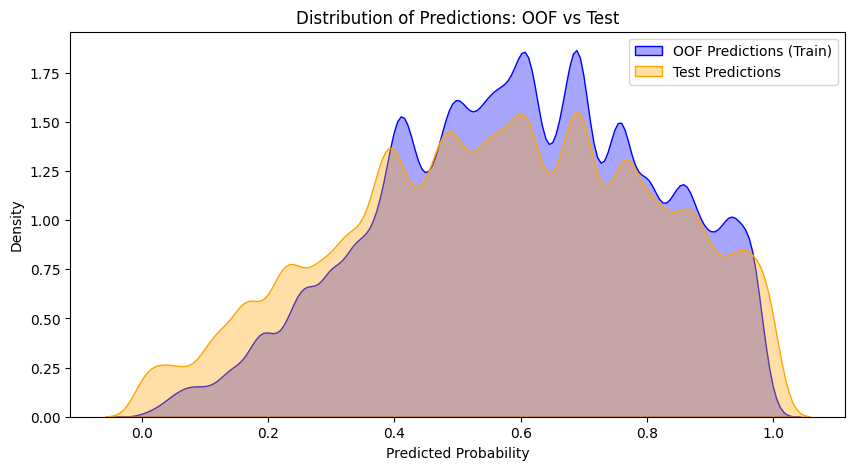

In [49]:
# distribution of predictions
plt.figure(figsize=(10, 5))
sns.kdeplot(scaled_final_meta_oof_preds, label='OOF Predictions (Train)', fill=True, color='blue', alpha=0.35)
sns.kdeplot(scaled_final_meta_test_preds, label='Test Predictions', fill=True, color='orange', alpha=0.35)
plt.title('Distribution of Predictions: OOF vs Test')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()